In [1]:
import time
import numpy as np
import os
import os.path as op
import pandas as pd
import scipy.optimize as so
import pickle
import scipy as sp
import seaborn as sns
import glob

import matplotlib.pyplot as plt

#from idealObserver2 import io_with_derivations

"""
Created on: May 19, 2023
Latest update: July 11, 2023
Author: @zoeheez



Description: 

This script is a draft for testing different processing and analysis pipline for pupil data.

"""

'\nCreated on: May 19, 2023\nLatest update: July 11, 2023\nAuthor: @zoeheez\n\n\n\nDescription: \n\nThis script is a draft for testing different processing and analysis pipline for pupil data.\n\n'

In [2]:
# import all pkl files 

# get the project directory (cbandit)
proj_dir = os.path.normpath(os.getcwd()) #+ os.sep + os.pardir)
print(f'project directory: {proj_dir}')

f_pupil = open(proj_dir+"/pupil_epochs_all_new2.pkl","rb")
pupil_data_holder = pickle.load(f_pupil)

f_behavioral = open(proj_dir+"/behavioral_data_cleaned.pkl","rb")
behavioral_data_holder = pickle.load(f_behavioral)

f_model = open(proj_dir+"/model_based_variables.pkl","rb")
model_data_holder = pickle.load(f_model)

data_ff = pd.read_pickle('outputs_ff.p')
valid_sub = valid_sub = np.array(data_ff['subnums'])[:-2]

print('valid subjects: ', valid_sub)

print('invalid sessions: subject 24, sess 6; subject 34, sess 8')
        #if sub+1 == 24 and sess+1 == 6:
        #    continue
        #if sub+1 == 34 and sess+1 == 8:
        #    continue

project directory: /home/wah016/cbandit
valid subjects:  [ 1  2  3  4  6  8 10 11 12 13 14 16 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55 56
 57 58 59 60]
invalid sessions: subject 24, sess 6; subject 34, sess 8


In [3]:
data_ff.keys()

dict_keys(['subnums', 'subids', 'paramnames', 'parampairnames', 'tp_idx', 'params', 'params_raw', 'params_gt10', 'mdl_accuracy', 'params_alldata', 'nobs', 'reg_avg', 'reg_std', 'reg_cor', 'params_avg', 'params_ste', 'mdl_accuracy_avg', 'mdl_accuracy_ste', 'nobs_avg', 'reg_avg_avg', 'reg_std_avg', 'reg_cor_avg', 'reg_avg_ste', 'reg_std_ste', 'reg_cor_ste'])

In [4]:
data_ff['params_alldata']['vol'].to_numpy().flatten().min()

0.006071067149682751

In [5]:
data_ff['params_alldata']['vol'].to_numpy().flatten().max()

0.4554553707245781

In [6]:
data_ff['params_alldata']['vol'].to_numpy().flatten().sort()

In [7]:
arr = np.sort(data_ff['params_alldata']['vol'].to_numpy().flatten())

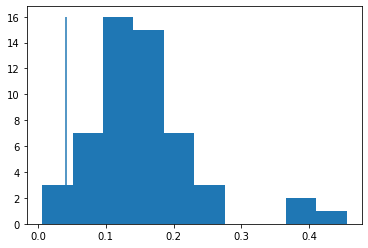

In [8]:
plt.hist(arr)
plt.vlines(x=1/24, ymin=0, ymax=16)

In [9]:
import numpy as np
from scipy import stats

stats.ttest_1samp(arr, 1/24)

Ttest_1sampResult(statistic=9.832009601399655, pvalue=1.5163785428351054e-13)

Other things to add after filtering:
1. determine whether each trial is a 'switch' or 'stay' choice
2. determine whether the NEXT trial is a switch or stay choice
3. determine whether the current observation has increased or decreased outcome

1. find the observed changepoint (aka: current trial = stay, changepoint = True)
2. find the high-to-low changepoint (aka: decreased outcome = True, changepoint = True)
3. find the trial_after_forced
4. find the trial_after_cp

In [10]:
def trial_after_forced(forced_arr):
    to_return = np.zeros(len(forced_arr))
    count = 0
    for i in range(len(forced_arr)):
        if forced_arr[i]:
            to_return[i] = 0
            count = 0
        else:
            count += 1
            to_return[i] = count
            
    return to_return.astype(int)


def trial_after_cp(cp_arr):
    to_return = np.zeros(len(cp_arr))
    
    count = 0
    for i in range(len(cp_arr)):
        if cp_arr[i]:
            count = 1
        
        to_return[i] = count
        
        if count >= 1:
            count += 1
            
    return to_return.astype(int)

def outcome_change(outcome_arr):
   
    increase_from_last = np.array([outcome_arr[i] - outcome_arr[i-1] for i in range(1, len(outcome_arr))])
    increase_from_last = np.insert(increase_from_last, 0, outcome_arr[0])
    
    return increase_from_last

In [11]:
rt_next = np.array(pupil_data['rt'][1:])
rt_next = np.insert(rt_next, len(rt_next), np.nan)
rt_next

NameError: name 'pupil_data' is not defined

In [12]:

# concatenate all three
nsess = 8

joint_data_all = {}
for sub in valid_sub-1:
    joint_data_all[f'sub{sub+1}'] = {}
    for sess in range(nsess):
        if sub+1 == 24 and sess+1 == 6:
            continue
        if sub+1 == 34 and sess+1 == 8:
            continue
            
        pupil_data = pupil_data_holder[f'sub{sub+1}'][f'sess{sess+1}']
        rt_next = np.array(pupil_data['rt'][1:])
        rt_next = np.insert(rt_next, len(rt_next), np.nan)
        pupil_data['rt_next'] = rt_next
        
        behavioral_data = behavioral_data_holder[f'sub{sub+1}'][f'sess{sess+1}']
        model_data = model_data_holder[f'sub{sub+1}'][f'sess{sess+1}']
     
        
        # TODO: fix the behavioral data first
        # concatenate with behavioral data
        #behavioral_sub = data_list[sub]
        #behavioral_example = behavioral_sub[behavioral_sub['sess']==1]
        #behavioral_example

        joint_data = pd.concat([pupil_data, behavioral_data, model_data], axis=1)
        joint_data = joint_data[joint_data['valid']==True].reset_index()
        
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}'] = joint_data
        k = len(joint_data_all[f'sub{sub+1}'][f'sess{sess+1}'])
        if k < 96:
            print(f'sub{sub+1} sess{sess+1} has {k} invalid trials.')
        # 
        
        
        # switch, switch_next
        
        # identify the switch trial
        choices_temp = joint_data['choices']
        # all the switches (including the forced trials)
        switch_list = ~np.array([(i==0 or choices_temp[i] == choices_temp[i-1]) for i in range(len(choices_temp))]) #* args['kept']
        switch_next_list = ~np.array([(i==len(choices_temp)-1 or choices_temp[i] == choices_temp[i+1]) for i in range(len(choices_temp))])
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['switch'] = switch_list
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['switch_next'] = switch_next_list
        
        # outcome change
        outcome_change_list = outcome_change(joint_data['outcomes'])
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['outcome_change'] = outcome_change_list
        
        # find observed changepoints: changepoint == True, switch_list == False
        #observed_changepoints = ~switch_list * joint_data['changepoints']
        
        # find trial_after_forced
        num_trial_after_forced = trial_after_forced(joint_data['forced'])
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['trial_after_forced'] = num_trial_after_forced
        
        # find trial after cp
        num_trial_after_cp = trial_after_cp(joint_data['changepoints'])
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['trial_after_cp'] = num_trial_after_cp
        
        

sub29 sess5 has 95 invalid trials.


In [13]:
# create a binary pickle file 
f = open("joint_data_all_new2.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(joint_data_all,f)

# close file
f.close()

In [14]:
test_data = joint_data_all['sub3']['sess7']
test_data['trial_after_forced']

0     0
1     0
2     0
3     0
4     1
     ..
91    4
92    5
93    6
94    7
95    8
Name: trial_after_forced, Length: 96, dtype: int64

In [15]:
test_data.columns

Index(['index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen

In [16]:
test_data.head()

,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,pupil_size_outcome,...,ER_diff_after,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp
0,0,0,0.615,"[3.4943289452924784, 3.6201503559856016, 3.658...","[2.6047685529150186, 2.600503519914743, 2.6720...","[3.8890624453706484, 3.9150637885583848, 3.918...",3.646467,"[3.3323658599351598, 3.3778578992816937, 3.367...",3.133123,"[2.6047685529150186, 2.600503519914743, 2.6720...",...,-6.515526,0.000000,-0.298704,0.000000,0.000000,False,True,43.0,0,0
1,1,1,0.636,"[1.8177416161235898, 1.7776879685920277, 1.566...","[1.9212231295924718, 1.8965065125923266, 1.851...","[2.034466859233352, 2.0491064265226897, 1.9958...",2.034766,"[2.040376050998603, 2.0396342176679907, 2.0392...",1.600773,"[1.9212231295924718, 1.8965065125923266, 1.851...",...,19.685362,0.298704,-0.161364,0.000000,0.000000,True,True,22.0,0,0
2,2,2,0.454,"[0.9669905894364189, 0.8438690356157356, 0.990...","[1.541031168906833, 1.6240573194756656, 1.6910...","[1.1373285211494024, 1.232087723277475, 1.2628...",1.315238,"[1.3305806630054169, 1.6590046688950184, 1.702...",1.220098,"[1.541031168906833, 1.6240573194756656, 1.6910...",...,-15.103694,0.161364,-0.150929,0.000000,-0.124075,True,True,-20.0,0,0
3,3,3,0.577,"[1.5876280900245823, 1.6163412603173137, 1.597...","[1.3969032157077375, 1.4081162165824346, 1.421...","[1.6974839477160701, 1.6094846742274511, 1.596...",1.601743,"[1.5744877161114594, 1.5816334144541917, 1.579...",1.186829,"[1.3969032157077375, 1.4081162165824346, 1.421...",...,19.138361,0.150929,-0.116529,0.124075,-0.089672,True,False,19.0,0,0
4,4,4,0.982,"[1.2516132300292016, 1.2136400193782357, 1.193...","[0.41902213923709236, 0.4665330593896537, 0.51...","[0.5481876823105208, 0.604136001762113, 0.6214...",0.836744,"[1.0811051556281805, 1.0832660528791125, 0.961...",0.743950,"[0.41902213923709236, 0.4665330593896537, 0.51...",...,20.856915,-0.116529,-0.310110,-0.089672,-0.179312,False,False,3.0,1,0


In [110]:
# 1. combine across sessions for each subject
joint_data_by_sub = {}
for sub in valid_sub-1:
    joint_data_each_sub = pd.DataFrame()
    for sess in range(nsess):
        if sub+1 == 24 and sess+1 == 6:
            continue
        if sub+1 == 34 and sess+1 == 8:
            continue
            
        sample_data = joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']
        sample_data['sess'] = np.ones(len(sample_data)) * (sess+1)

        joint_data_each_sub = pd.concat([joint_data_each_sub, sample_data], axis=0)
    
    joint_data_each_sub = joint_data_each_sub.reset_index()
    joint_data_by_sub[f'sub{sub+1}'] = joint_data_each_sub

In [111]:
joint_data_each_sub


,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp,sess
0,0,0,0,14.307,"[0.4512524809076589, 0.47358640073485514, 0.47...","[1.3595958934327117, 1.375846837164174, 1.3522...","[0.9012625772442107, 0.923419756338039, 0.9813...",1.090340,"[1.1884758345129462, 1.1722194968436488, 1.195...",1.232890,...,0.000000,-0.099304,0.000000,0.000000,False,True,58.0,0,0,1.0
1,1,1,1,1.950,"[0.3728106435716297, 0.30595267957474026, 0.26...","[0.16848354928987766, 0.17813835699020253, 0.1...","[0.13093264392753065, 0.14002343053940322, 0.1...",0.347182,"[0.49289570133733357, 0.5141890876747841, 0.56...",0.340092,...,0.099304,-0.286503,0.000000,0.000000,True,True,21.0,0,0,1.0
2,2,2,2,1.203,"[0.4531594955862836, 0.4505523408239858, 0.446...","[-0.9279685749872779, -0.9453852131180074, -0....","[0.8564177916882505, 0.874603580597752, 0.9877...",0.664230,"[0.4956462720515597, 0.4535649306316723, 0.427...",-0.219130,...,0.286503,-0.124505,0.000000,0.121558,True,False,-69.0,0,0,1.0
3,3,3,3,0.836,"[0.2493712974503475, 0.1797073611349643, 0.160...","[-0.6720455772971883, -0.7191280822572133, -0....","[1.0092325215058655, 1.0060257517126063, 1.014...",1.172001,"[1.3851556862149352, 1.388967864655642, 1.3178...",0.612900,...,-0.124505,-0.367036,0.121558,-0.008532,False,True,2.0,0,0,1.0
4,4,4,4,0.886,"[0.2329468694457934, 0.2195645528616627, 0.246...","[1.7544874871463856, 1.7720780239957616, 1.805...","[0.8322483658106244, 0.8368113607088992, 0.775...",0.847741,"[0.8457479447273881, 0.872420260350685, 0.9672...",1.237052,...,0.367036,-0.067325,0.008532,-0.035290,True,False,71.0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,91,91,91,1.142,"[0.67943674845904, 0.7272363341078137, 0.73705...","[0.5511960490811909, 0.5499120983188762, 0.581...","[1.0707077050777225, 1.0654853260524422, 1.070...",1.213163,"[1.3801842435307121, 1.323949527624748, 1.1854...",0.497171,...,-0.190555,-0.310069,0.002049,-0.193693,False,True,14.0,4,29,8.0
764,92,92,92,0.316,"[-0.17780774209706132, -0.13794868236501812, -...","[-0.8800874249291134, -0.863458312754363, -0.8...","[-0.14873885096615147, -0.11531997069426185, -...",0.221271,"[0.32346568708713375, 0.35393766046567277, 0.4...",0.406316,...,0.310069,0.174400,0.193693,0.094960,True,False,17.0,5,30,8.0
765,93,93,93,0.412,"[-1.203478368664157, -1.1643138433366318, -1.1...","[-3.327919441521653, -3.3458417071503943, -3.3...","[-1.1940200358695918, -1.1961699578124045, -1....",-1.551658,"[-1.7172245184480575, -1.7368905531884036, -1....",-2.623501,...,0.174400,-0.278061,0.094960,-0.209280,False,True,-18.0,6,31,8.0
766,94,94,94,0.319,"[-1.6546526797253853, -1.6049083492062692, -1....","[-0.23448572896024178, -0.11422985799373579, -...","[-1.558495613955596, -1.5328490750914376, -1.4...",-1.222526,"[-1.106845834894351, -1.1308387794174326, -1.1...",-0.842620,...,0.278061,-0.185099,0.209280,-0.151476,True,True,-6.0,7,32,8.0


In [112]:
joint_data_by_sub.keys()

dict_keys(['sub1', 'sub2', 'sub3', 'sub4', 'sub6', 'sub8', 'sub10', 'sub11', 'sub12', 'sub13', 'sub14', 'sub16', 'sub19', 'sub20', 'sub21', 'sub22', 'sub23', 'sub24', 'sub25', 'sub26', 'sub27', 'sub28', 'sub29', 'sub30', 'sub31', 'sub32', 'sub33', 'sub34', 'sub35', 'sub36', 'sub37', 'sub38', 'sub39', 'sub40', 'sub41', 'sub43', 'sub44', 'sub45', 'sub47', 'sub48', 'sub49', 'sub50', 'sub51', 'sub52', 'sub53', 'sub54', 'sub55', 'sub56', 'sub57', 'sub58', 'sub59', 'sub60'])

In [113]:
# 2. plot the average pupil trace for individual subjects
annot_kws = {'prop':{'family':'monospace', 'weight':'bold', 'size':12}}
sns.set_theme(style="whitegrid")

def plot_pupil_responses(epoch_time, Y, labels, where):
    gridsize = (1,1)
    fig = plt.figure(figsize=(6, 4))
    ax4 = plt.subplot2grid(gridsize, (0, 0))

    x = epoch_time
    num_lines = len(Y)
    y1_all = []
    for i in range(num_lines):
        y1_or = Y[i]
        
        y1 = np.mean(y1_or,axis=0)
        y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        ax4.plot(x, y1, label=labels[i])
        ax4.axvline(x=0,color=".2", linestyle="--")

        ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        y1_all.append(y1)

    ax4.set_title(f'Pupil change on around {where}',fontsize=18) #Pupil change to different change points 
    ax4.set_ylabel('average pupil change',fontsize=18)
    ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
    #ax4.set_ylim([-0.08, 0.08])
    ax4.legend(prop={"size":16})
    plt.legend()
    
    return y1_all
        

In [114]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

dict_keys(['t_pre_response', 't_response', 't_outcome'])

In [115]:
joint_data=joint_data_by_sub['sub1']

In [116]:
joint_data

,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp,sess
0,0,0,0,0.873,"[-0.13285487334831725, -0.15435727323074105, -...","[0.07491006887873684, 0.13786000971694218, 0.1...","[0.11437311041501608, 0.10994014858446984, 0.1...",0.279017,"[0.353667051165722, 0.39952404529320773, 0.433...",0.475576,...,0.000000,-0.117293,0.000000,0.000000,False,False,48.0,0,0,1.0
1,1,1,1,0.503,"[0.14530678606560862, 0.1443430154502174, 0.24...","[0.23190501894722576, 0.17961922205809192, 0.1...","[0.34474857188501473, 0.35575292963603705, 0.3...",0.299246,"[0.3427030080472347, 0.3527936049405821, 0.374...",1.147825,...,-0.117293,-0.143198,0.000000,0.000000,False,True,22.0,0,0,1.0
2,2,2,2,0.948,"[0.22792893919942742, 0.15482785060969537, 0.1...","[0.1730485920638111, 0.15684330963330576, 0.18...","[-0.5578585701312097, -0.5368051541620953, -0....",-0.249000,"[-0.043562563000114525, -0.010950897831385292,...",-0.182329,...,0.143198,-0.013064,0.000000,-0.006041,True,False,-20.0,0,0,1.0
3,3,3,3,0.633,"[-0.04115643605480424, -0.011971396588699315, ...","[-0.02837186777614119, 0.004751287527410095, 0...","[0.9398780279838435, 0.9354819044102489, 0.927...",0.780104,"[0.6531173173194468, 0.6612715975477902, 0.646...",0.399992,...,-0.013064,-0.420074,-0.006041,0.022409,False,False,50.0,0,0,1.0
4,4,4,4,1.754,"[0.7752312920948785, 0.8033788108457145, 0.831...","[0.467254551806917, 0.46196730826422516, 0.473...","[0.13627293908167493, 0.0938579818830942, 0.08...",-0.051292,"[-0.1988164400882881, -0.1855046140065632, -0....",0.438572,...,-0.420074,-0.341523,0.022409,-0.011922,False,False,-41.0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,91,91,91,1.292,"[0.9440574455329321, 0.9797740013763789, 1.000...","[-0.2881632675597719, -0.2400962148296614, -0....","[1.0870597990222244, 1.0612094153744953, 1.048...",1.108661,"[1.1411791340983253, 1.0926622014125866, 1.073...",0.322755,...,0.471632,-0.055144,0.518444,-0.018568,True,False,37.0,4,16,8.0
764,92,92,92,0.373,"[1.168299084483247, 1.1670923863513962, 1.1944...","[0.9511351459807956, 0.9523740032809924, 0.954...","[1.4614223571061273, 1.5293144197778896, 1.550...",2.093780,"[2.4096743256709146, 2.495328107614667, 2.5140...",1.451788,...,-0.055144,-0.248089,-0.018568,-0.181464,False,False,-7.0,5,17,8.0
765,93,93,93,0.350,"[0.5128540402488411, 0.5474079431799694, 0.595...","[1.0246539725728203, 1.0375120549738277, 1.049...","[0.6125205116700386, 0.6285798356603844, 0.644...",0.731417,"[0.7648195837852088, 0.7834854352008632, 0.793...",1.193627,...,-0.248089,-0.363826,-0.181464,-0.264893,False,False,3.0,6,18,8.0
766,94,94,94,0.354,"[0.06467445175805148, 0.06351523679661694, 0.0...","[-0.6962144444896675, -0.6686769003726343, -0....","[-0.1359992371571531, -0.16171914755336544, -0...",-0.317786,"[-0.3805532585940814, -0.42342857433207653, -0...",-0.712954,...,-0.363826,-0.404911,-0.264893,-0.244399,False,True,8.0,7,19,8.0


In [117]:
joint_data['pupil_change_response']

0      [0.47757688997441433, 0.5234338841019001, 0.55...
1      [0.11745386582914089, 0.1275444627224883, 0.14...
2      [-0.23222515232129334, -0.1996134871525641, -0...
3      [0.604369662327627, 0.6125239425559704, 0.5980...
4      [-1.0554489619775056, -1.0421371358957807, -0....
                             ...                        
763    [0.13242391863585357, 0.08390698595011492, 0.0...
764    [1.1617997870953838, 1.2474535690391364, 1.266...
765    [0.18465528931901398, 0.20332114073466845, 0.2...
766    [-0.3474537690349683, -0.3903290847729634, -0....
767    [0.5810645010935362, 0.580398296914611, 0.5818...
Name: pupil_change_response, Length: 768, dtype: object

In [118]:
def make_numpy(lst):
    return np.array([np.array(lst[i]) for i in range(len(lst))])
    
    
    

In [119]:
make_numpy(joint_data['pupil_change_response']).shape

(768, 127)

In [27]:
#[len(joint_data['pupil_change_response'][i]) for i in range(len(joint_data['pupil_change_response']))]

In [28]:
# get the average for each subject

for sub in valid_sub-1:
    joint_data_by_sub[f'sub{sub+1}']

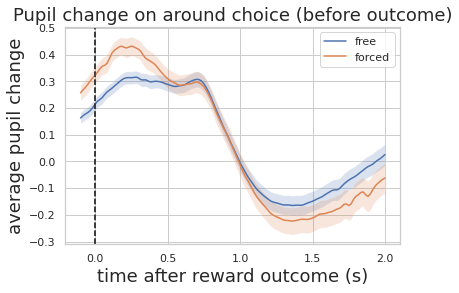

In [29]:
# plot the pupil trace based on trial types
types = ['free', 'forced']
event = 'response'

to_plot1 = joint_data[joint_data[types[0]] == True]
to_plot2 = joint_data[joint_data[types[1]] == True]

to_plot1_trace = np.array(to_plot1[f'pupil_change_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_change_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_response'], [to_plot1_trace, to_plot2_trace], types, 'choice (before outcome)')

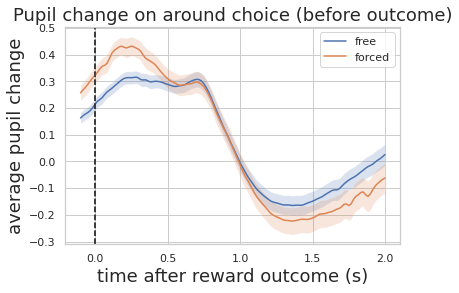

In [24]:
# plot the pupil trace based on trial types
types = ['free', 'forced']
event = 'response'

to_plot1 = joint_data[joint_data[types[0]] == True]
to_plot2 = joint_data[joint_data[types[1]] == True]

to_plot1_trace = np.array(to_plot1[f'pupil_change_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_change_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_response'], [to_plot1_trace, to_plot2_trace], types, 'choice (before outcome)')

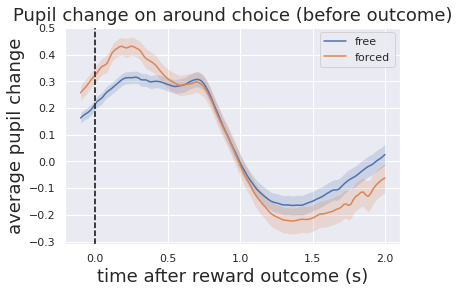

In [22]:
# plot the pupil trace based on trial types
types = ['free', 'forced']
event = 'response'

to_plot1 = joint_data[joint_data[types[0]] == True]
to_plot2 = joint_data[joint_data[types[1]] == True]

to_plot1_trace = np.array(to_plot1[f'pupil_change_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_change_{event}'].to_list())
                          
y_test = plot_pupil_responses(t_epochs['t_response'], [to_plot1_trace, to_plot2_trace], types, 'choice (before outcome)')

In [30]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

(52, 2, 25)


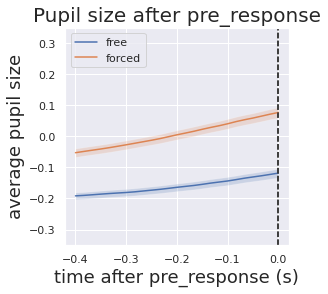

In [24]:
gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

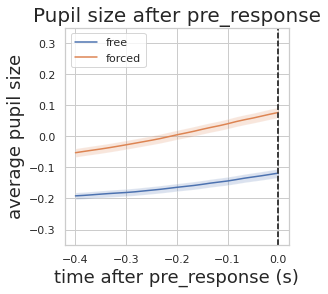

In [31]:
gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 4, 25)


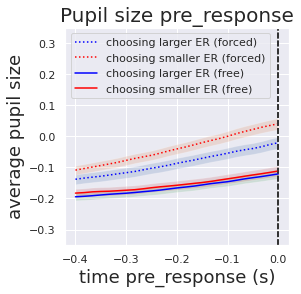

In [49]:
# plot the average for all subjects

types = ['choosing larger ER (forced)', 'choosing smaller ER (forced)','choosing larger ER (free)', 'choosing smaller ER (free)']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['ER_diff_before'] > 0]
    to_plot2 = joint_data[joint_data['ER_diff_before'] < 0]
    to_plot3 = joint_data_free[joint_data_free['ER_diff_before'] > 0]
    to_plot4 = joint_data_free[joint_data_free['ER_diff_before'] < 0]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dotted', 'dotted', 'solid', 'solid']
linecolor = ['blue', 'red', 'blue', 'red']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 4, 25)


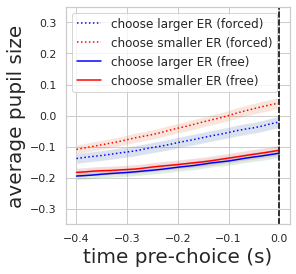

In [32]:
# plot the average for all subjects

types = ['choose larger ER (forced)', 'choose smaller ER (forced)','choose larger ER (free)', 'choose smaller ER (free)']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['ER_diff_before'] > 0]
    to_plot2 = joint_data[joint_data['ER_diff_before'] < 0]
    to_plot3 = joint_data_free[joint_data_free['ER_diff_before'] > 0]
    to_plot4 = joint_data_free[joint_data_free['ER_diff_before'] < 0]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(4, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dotted', 'dotted', 'solid', 'solid']
linecolor = ['blue', 'red', 'blue', 'red']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

#ax4.set_title(f'Pupil {metric} pre-choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time pre-choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend()
        

(52, 4, 127)


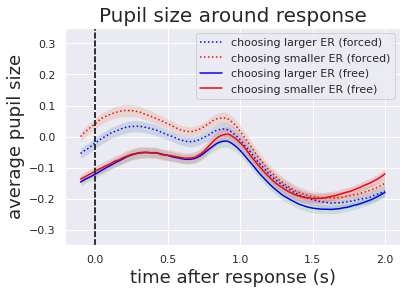

In [47]:
# plot the average for all subjects

types = ['choosing larger ER (forced)', 'choosing smaller ER (forced)','choosing larger ER (free)', 'choosing smaller ER (free)']
metric = 'size'
event = 'response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['ER_diff_before'] > 0]
    to_plot2 = joint_data[joint_data['ER_diff_before'] < 0]
    to_plot3 = joint_data_free[joint_data_free['ER_diff_before'] > 0]
    to_plot4 = joint_data_free[joint_data_free['ER_diff_before'] < 0]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    
    num_lines = len(Y)
    Y_all = []
    
    
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dotted', 'dotted', 'solid', 'solid']
linecolor = ['blue', 'red', 'blue', 'red']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 4, 127)


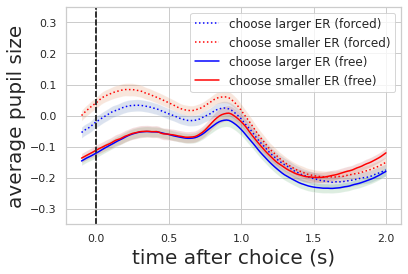

In [33]:
# plot the average for all subjects

types = ['choose larger ER (forced)', 'choose smaller ER (forced)','choose larger ER (free)', 'choose smaller ER (free)']
metric = 'size'
event = 'response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced']==True]
    joint_data_free = joint_data_temp[joint_data_temp['free']==True]
    
    
    to_plot1 = joint_data[joint_data['ER_diff_before'] > 0]
    to_plot2 = joint_data[joint_data['ER_diff_before'] < 0]
    to_plot3 = joint_data_free[joint_data_free['ER_diff_before'] > 0]
    to_plot4 = joint_data_free[joint_data_free['ER_diff_before'] < 0]
    
    Y = [to_plot1, to_plot2, to_plot3, to_plot4]
    
    
    num_lines = len(Y)
    Y_all = []
    
    
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

linetype = ['dotted', 'dotted', 'solid', 'solid']
linecolor = ['blue', 'red', 'blue', 'red']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i], linestyle=linetype[i],color=linecolor[i])
    
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
#ax4.set_title(f'Pupil {metric} after choice',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
#ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
ax4.set_xlabel(f'time after choice (s)',fontsize=20)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":12})
#plt.legend(fontsize=12)
        

(52, 2, 187)


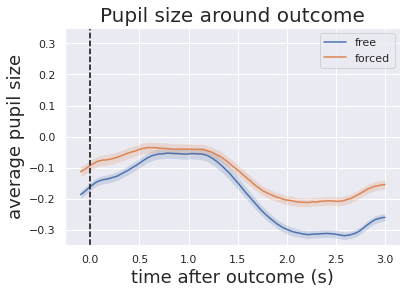

In [25]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


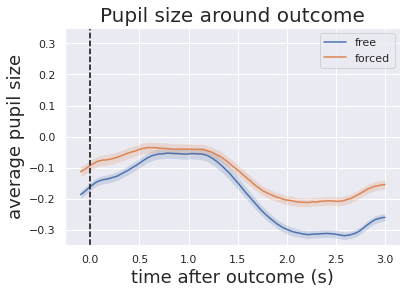

In [34]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


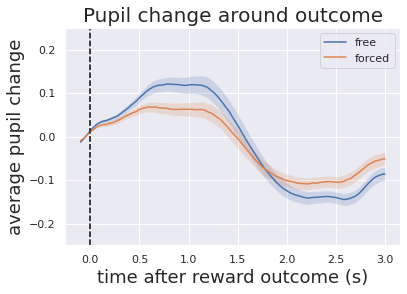

In [26]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil change',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
ax4.set_ylim([-0.25, 0.25])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


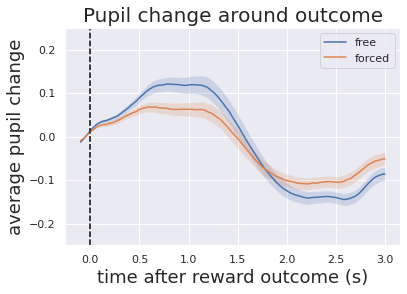

In [35]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil change',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
ax4.set_ylim([-0.25, 0.25])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


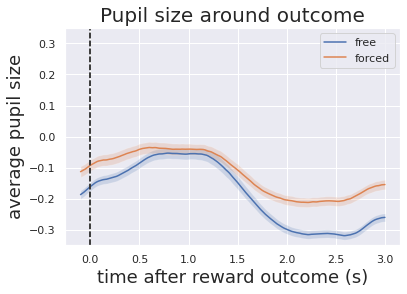

In [36]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil size',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        
    

(52, 2, 25)


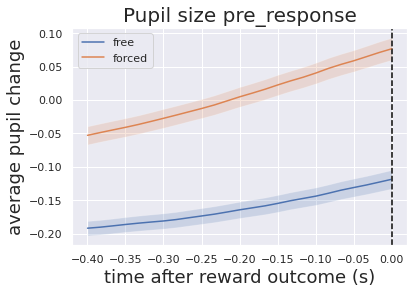

In [27]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'size'
event = 'pre_response'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil change',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
#ax4.set_ylim([-0.08, 0.08])
ax4.legend(prop={"size":16})
plt.legend()
        

In [28]:
joint_data.keys()

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_s

In [29]:
joint_data['outcome_change']

0      58.0
1      21.0
2     -69.0
3       2.0
4      71.0
       ... 
763    14.0
764    17.0
765   -18.0
766    -6.0
767   -17.0
Name: outcome_change, Length: 768, dtype: float64

(52, 2, 187)


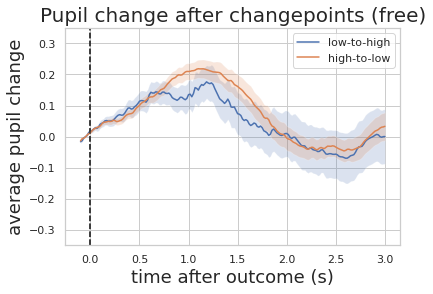

In [34]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (free)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


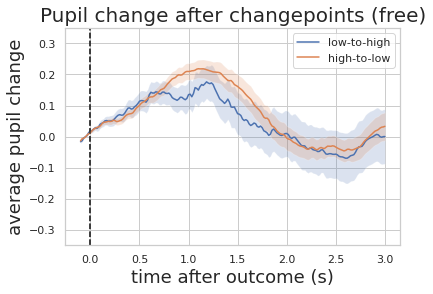

In [31]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (free)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


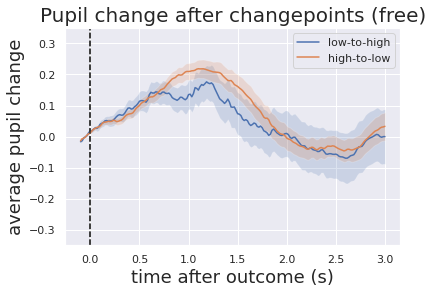

In [42]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (free)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


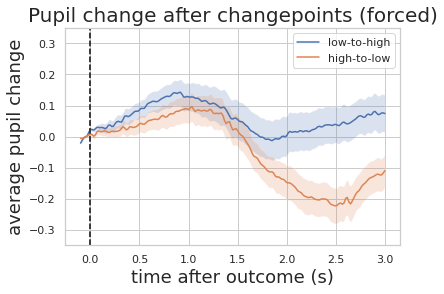

In [35]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == False]

    
    
    to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (forced)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

In [36]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

(52, 2, 187)


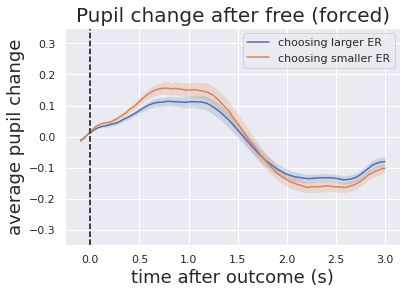

In [37]:
# plot the average for all subjects

types = 'free'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['choosing larger ER', 'choosing smaller ER']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[(joint_data['ER_diff_before']>0)]
    to_plot2 = joint_data[(joint_data['ER_diff_before']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (forced)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


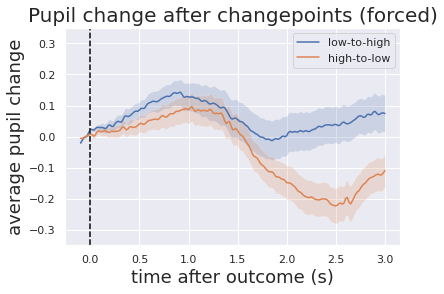

In [43]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == False]

    
    
    to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (forced)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


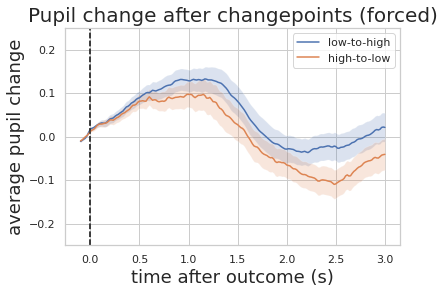

In [37]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == False]
    

    
    #to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    #to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    to_plot1 = joint_data[(joint_data['trial_after_cp'] > 0) & (joint_data['trial_after_cp'] <= 5) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data['trial_after_cp'] > 0) & (joint_data['trial_after_cp'] <= 5) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (forced)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.25, 0.25])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


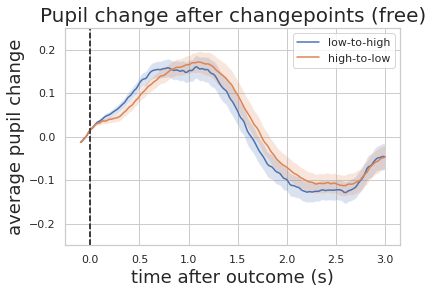

In [38]:
# plot the average for all subjects

types = 'changepoints'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['low-to-high', 'high-to-low']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]
    

    
    #to_plot1 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']>0)]
    #to_plot2 = joint_data[(joint_data[types] == True) & (joint_data['outcome_change']<0)]
    
    to_plot1 = joint_data[(joint_data['trial_after_cp'] > 0) & (joint_data['trial_after_cp'] <= 5) & (joint_data['outcome_change']>0)]
    to_plot2 = joint_data[(joint_data['trial_after_cp'] > 0) & (joint_data['trial_after_cp'] <= 5) & (joint_data['outcome_change']<0)]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} after {types} (free)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.25, 0.25])
ax4.legend(prop={"size":16})
plt.legend()
        

In [67]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

(52, 2, 187)


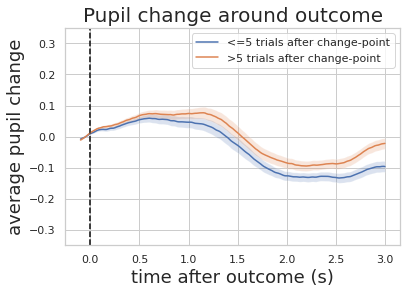

In [39]:
# plot the average for all subjects

types = 'trial_after_cp'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['<=5 trials after change-point', '>5 trials after change-point']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['forced'] == True]

    
    
    to_plot1 = joint_data[joint_data[types] <= 3]
    to_plot2 = joint_data[joint_data[types] > 3]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 127)


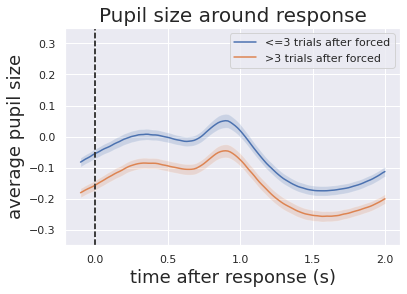

In [44]:
# plot the average for all subjects

types = 'trial_after_forced'
metric = 'free'
event = 'response'
label = f'pupil_{metric}_{event}'
labels = ['<=3 trials after forced', '>3 trials after forced']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[joint_data[types] <= 3]
    to_plot2 = joint_data[joint_data[types] > 3]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

In [ ]:
# plot the average for all subjects

types = 'trial_after_forced'
metric = 'free'
event = 'response'
label = f'pupil_{metric}_{event}'
labels = ['<=3 trials after forced', '>3 trials after forced']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[joint_data[types] <= 3]
    to_plot2 = joint_data[joint_data[types] > 3]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 4, 187)


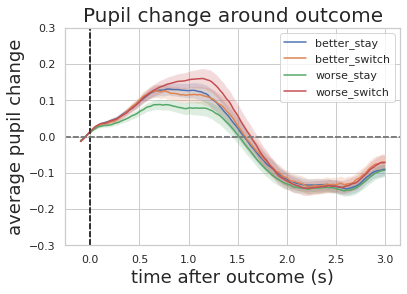

In [73]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better_stay', 
                      'better_switch',
                      'worse_stay',
                      'worse_switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.3, 0.3])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 4, 187)


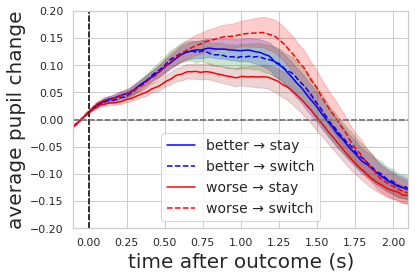

In [41]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better → stay', 
                      'better → switch',
                      'worse → stay',
                      'worse → switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linetype = ['solid', 'dashed', 'solid', 'dashed']
linecolor = ['blue', 'blue', 'red', 'red']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

(52, 4, 187)


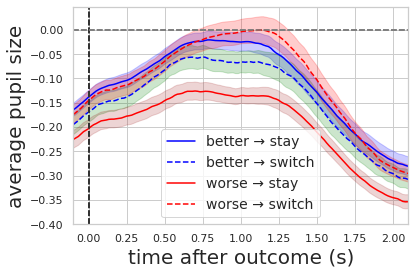

In [135]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better → stay', 
                      'better → switch',
                      'worse → stay',
                      'worse → switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all) 
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linetype = ['solid', 'dashed', 'solid', 'dashed']
linecolor = ['blue', 'blue', 'red', 'red']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i],color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=20)
ax4.set_xlabel(f'time after {event} (s)',fontsize=20)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

In [43]:
num_lines

4

In [54]:
joint_data_new.columns 
# relevant column names: 
# pupil (current trial): 
#- 'pupil_size_pre_response', 'pupil_size_avg_pre_response'
#- 'pupil_size_response','pupil_size_avg_response'

# pupil (prev trial):
#- all things related to outcome
# behavioral: choices_new (0 or 1), mean_chosen, mean_unchosen,  ER_diff_before (>0), EU_diff_before, UU_diff_before
# ***better check how diff_before was calculated

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [58]:
joint_data_new['index'].to_list()

[4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 16,
 17,
 18,
 19,
 20,

In [64]:
# test
test_arr = np.array([1,2,3])
test_arr = np.insert(test_arr, -1, 10)
[test_arr[i+1] for i in range(len(test_arr)-1)]

[2, 10, 3]

In [67]:
holder_arr = joint_data_new['pupil_size_avg_outcome'].to_numpy()
holder_arr = np.insert(holder_arr, 0, 0)[:-1]
print(len(joint_data_new['pupil_size_avg_outcome'].to_numpy()))
print(len(holder_arr))
print(holder_arr)

512
512
[ 0.00000000e+00  1.43798055e+00  3.00452432e-01  6.43145113e-01
  5.51386874e-01  2.08526596e-01  5.66116912e-01  4.41847508e-01
  1.25237678e+00  1.31529560e+00  1.14355537e+00  1.62274218e+00
  8.25195243e-01  1.39315035e+00  9.22304020e-01  1.75331920e+00
  1.46001383e+00  5.48133949e-01  2.41618129e-01  6.37112508e-01
  4.00426879e-01 -5.90732835e-01  3.12202108e-02  2.45067993e-01
 -4.89423800e-02 -5.48333836e-01 -7.10585354e-01 -6.93783264e-01
 -6.68289121e-01 -9.16399976e-01 -8.39465550e-01 -1.14403707e+00
 -1.03118529e+00 -9.65546125e-01 -6.52010513e-01 -1.08653355e+00
 -7.73808966e-01 -5.55559991e-01 -2.19644259e-01 -9.09351591e-01
 -1.16790148e+00 -1.61720623e+00 -1.39608809e+00 -1.26679740e+00
 -1.22978973e+00 -4.64153965e-01 -1.28575195e+00 -9.58436655e-01
 -5.23721523e-01 -2.35874799e-01 -8.05975232e-01 -1.83110343e-01
 -2.33880299e-01  7.85575643e-02 -7.34710348e-01 -7.40989709e-01
 -4.16570074e-01  1.24903068e+00  7.30104395e-01  1.71776943e-01
  3.63017494e-01 

In [76]:
joint_data_new

,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,switch_next,outcome_change,trial_after_forced,trial_after_cp,sess,prev_pupil_size_avg_outcome,prev_pupil_change_avg_outcome,prev_pupil_change_avg_outcome1,prev_pupil_change_avg_outcome2,prev_pupil_change_avg_outcome3
0,0,0,0,0.873,"[-0.13285487334831725, -0.15435727323074105, -...","[0.07491006887873684, 0.13786000971694218, 0.1...","[0.11437311041501608, 0.10994014858446984, 0.1...",0.279017,"[0.353667051165722, 0.39952404529320773, 0.433...",0.475576,...,False,48.0,0,0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1,1,0.503,"[0.14530678606560862, 0.1443430154502174, 0.24...","[0.23190501894722576, 0.17961922205809192, 0.1...","[0.34474857188501473, 0.35575292963603705, 0.3...",0.299246,"[0.3427030080472347, 0.3527936049405821, 0.374...",1.147825,...,True,22.0,0,0,1.0,0.143308,-0.099852,-0.279732,-0.231277,0.048455
2,2,2,2,0.948,"[0.22792893919942742, 0.15482785060969537, 0.1...","[0.1730485920638111, 0.15684330963330576, 0.18...","[-0.5578585701312097, -0.5368051541620953, -0....",-0.249000,"[-0.043562563000114525, -0.010950897831385292,...",-0.182329,...,False,-20.0,0,0,1.0,0.349440,0.249212,-0.348056,0.340723,0.688779
3,3,3,3,0.633,"[-0.04115643605480424, -0.011971396588699315, ...","[-0.02837186777614119, 0.004751287527410095, 0...","[0.9398780279838435, 0.9354819044102489, 0.927...",0.780104,"[0.6531173173194468, 0.6612715975477902, 0.646...",0.399992,...,False,50.0,0,0,1.0,-0.001665,-0.183719,-0.011363,-0.103675,-0.092312
4,4,4,4,1.754,"[0.7752312920948785, 0.8033788108457145, 0.831...","[0.467254551806917, 0.46196730826422516, 0.473...","[0.13627293908167493, 0.0938579818830942, 0.08...",-0.051292,"[-0.1988164400882881, -0.1855046140065632, -0....",0.438572,...,False,-41.0,1,0,1.0,0.392350,0.293002,-0.014543,0.652830,0.667373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,91,91,91,1.292,"[0.9440574455329321, 0.9797740013763789, 1.000...","[-0.2881632675597719, -0.2400962148296614, -0....","[1.0870597990222244, 1.0612094153744953, 1.048...",1.108661,"[1.1411791340983253, 1.0926622014125866, 1.073...",0.322755,...,False,37.0,4,16,8.0,-1.263384,0.437317,1.715840,1.866506,0.150666
764,92,92,92,0.373,"[1.168299084483247, 1.1670923863513962, 1.1944...","[0.9511351459807956, 0.9523740032809924, 0.954...","[1.4614223571061273, 1.5293144197778896, 1.550...",2.093780,"[2.4096743256709146, 2.495328107614667, 2.5140...",1.451788,...,False,-7.0,5,17,8.0,0.528810,0.725325,0.324701,0.769680,0.444979
765,93,93,93,0.350,"[0.5128540402488411, 0.5474079431799694, 0.595...","[1.0246539725728203, 1.0375120549738277, 1.049...","[0.6125205116700386, 0.6285798356603844, 0.644...",0.731417,"[0.7648195837852088, 0.7834854352008632, 0.793...",1.193627,...,False,3.0,6,18,8.0,0.976042,0.019347,-1.080321,-0.793340,0.286981
766,94,94,94,0.354,"[0.06467445175805148, 0.06351523679661694, 0.0...","[-0.6962144444896675, -0.6686769003726343, -0....","[-0.1359992371571531, -0.16171914755336544, -0...",-0.317786,"[-0.3805532585940814, -0.42342857433207653, -0...",-0.712954,...,True,8.0,7,19,8.0,0.387129,-0.639210,-1.215140,-1.618074,-0.402934


In [75]:
joint_data_new['trial'].to_numpy()

array([[ 0,  0,  0],
       [ 1,  1,  1],
       [ 2,  2,  2],
       ...,
       [93, 93, 93],
       [94, 94, 94],
       [95, 95, 95]])

In [79]:
joint_data_new = joint_data_by_sub[f'sub1']

joint_data_new['prev_pupil_size_avg_outcome'] = np.insert(joint_data_new['pupil_size_avg_outcome'].to_numpy(), 0, 0)[:-1]
joint_data_new['prev_pupil_change_avg_outcome'] = np.insert(joint_data_new['pupil_change_avg_outcome'].to_numpy(), 0, 0)[:-1]
joint_data_new['prev_pupil_change_avg_outcome1'] = np.insert(joint_data_new['pupil_change_avg_outcome1'].to_numpy(), 0, 0)[:-1]
joint_data_new['prev_pupil_change_avg_outcome2'] = np.insert(joint_data_new['pupil_change_avg_outcome2'].to_numpy(), 0, 0)[:-1]
joint_data_new['prev_pupil_change_avg_outcome3'] = np.insert(joint_data_new['pupil_change_avg_outcome3'].to_numpy(), 0, 0)[:-1]

joint_data_new['mean_diff'] = joint_data_new['mean_chosen'].to_numpy() - joint_data_new['mean_unchosen'].to_numpy()
#joint_data_new['trial_int'] = joint_data_new['trial'].to_numpy().astype(int)
# next step: find the FREE, TRIAL > 0, (also exclude the first free?)
joint_data_use = joint_data_new[(joint_data_new['free'] == True) & (joint_data_new['index'] > 0)]



In [102]:
keys_to_include_ind = [#'rt', 
       'pupil_size_avg_pre_response', 
       'pupil_size_avg_response',
       'prev_pupil_size_avg_outcome', 
                       
       'pupil_change_avg_pre_response', 
       'pupil_change_avg_response', 
                       
       'prev_pupil_change_avg_outcome', 
        'prev_pupil_change_avg_outcome1',
       'prev_pupil_change_avg_outcome2', 
       'prev_pupil_change_avg_outcome3', 
                       
       'choices_new','mean_chosen', 'mean_unchosen', 'mean_diff','SD', 
         'ER_chosen_before', 
       'EU_chosen_before', 'UU_chosen_before',
       
                       'ER_sum_before', 'EU_sum_before', 'UU_sum_before', 
                       'ER_diff_before', 'EU_diff_before', 'UU_diff_before',
       'switch', 
       'trial_after_forced', 'trial_after_cp']
df = joint_data_new[keys_to_include_ind]

from scipy.stats import pearsonr

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p



,pupil_size_avg_pre_response,pupil_size_avg_response,prev_pupil_size_avg_outcome,pupil_change_avg_pre_response,pupil_change_avg_response,prev_pupil_change_avg_outcome,prev_pupil_change_avg_outcome1,prev_pupil_change_avg_outcome2,prev_pupil_change_avg_outcome3,choices_new,...,UU_chosen_before,ER_sum_before,EU_sum_before,UU_sum_before,ER_diff_before,EU_diff_before,UU_diff_before,switch,trial_after_forced,trial_after_cp
pupil_size_avg_pre_response,1.0***,0.83***,0.71***,0.16***,-0.23***,0.22***,-0.41***,-0.28***,0.14***,-0.02,...,-0.03,-0.01,-0.03,-0.06,0.03,-0.07*,0.01,-0.11**,0.03,-0.12***
pupil_size_avg_response,0.83***,1.0***,0.66***,0.13***,0.2***,0.23***,-0.36***,-0.22***,0.18***,-0.0,...,-0.02,0.01,-0.05,-0.04,0.04,-0.04,0.01,-0.07,0.03,-0.15***
prev_pupil_size_avg_outcome,0.71***,0.66***,1.0***,-0.21***,-0.3***,0.12***,-0.67***,-0.49***,0.13***,0.05,...,-0.01,0.05,-0.04,-0.02,0.0,-0.08*,0.01,-0.11**,0.03,-0.13***
pupil_change_avg_pre_response,0.16***,0.13***,-0.21***,1.0***,0.63***,-0.11**,0.1**,0.06,-0.06,-0.03,...,0.02,-0.05,0.04,0.02,-0.02,0.03,0.01,0.05,-0.04,0.02
pupil_change_avg_response,-0.23***,0.2***,-0.3***,0.63***,1.0***,-0.1**,0.18***,0.14***,-0.01,0.01,...,0.03,-0.0,0.02,0.04,-0.0,0.06,0.01,0.09**,-0.04,-0.01
prev_pupil_change_avg_outcome,0.22***,0.23***,0.12***,-0.11**,-0.1**,1.0***,0.63***,0.79***,0.84***,0.0,...,-0.01,-0.04,-0.03,-0.02,0.03,0.03,0.0,-0.01,0.03,-0.01
prev_pupil_change_avg_outcome1,-0.41***,-0.36***,-0.67***,0.1**,0.18***,0.63***,1.0***,0.95***,0.46***,-0.04,...,-0.0,-0.07,0.01,0.0,0.01,0.09*,-0.0,0.08*,-0.01,0.1**
prev_pupil_change_avg_outcome2,-0.28***,-0.22***,-0.49***,0.06,0.14***,0.79***,0.95***,1.0***,0.71***,-0.02,...,0.02,-0.08*,0.0,0.01,0.01,0.09*,0.01,0.07,0.0,0.07*
prev_pupil_change_avg_outcome3,0.14***,0.18***,0.13***,-0.06,-0.01,0.84***,0.46***,0.71***,1.0***,0.03,...,0.06,-0.07,-0.02,0.04,0.01,0.06,0.05,0.02,0.03,-0.01
choices_new,-0.02,-0.0,0.05,-0.03,0.01,0.0,-0.04,-0.02,0.03,1.0***,...,-0.01,0.07,0.01,-0.01,0.01,-0.1**,0.0,-0.06,0.03,0.06


In [103]:
corr_coef_list = pd.DataFrame()
p_val_list = pd.DataFrame()

c = 0
for sub in valid_sub-1:
    
    joint_data_new = joint_data_by_sub[f'sub{sub+1}']

    joint_data_new['prev_pupil_size_avg_outcome'] = np.insert(joint_data_new['pupil_size_avg_outcome'].to_numpy(), 0, 0)[:-1]
    joint_data_new['prev_pupil_change_avg_outcome'] = np.insert(joint_data_new['pupil_change_avg_outcome'].to_numpy(), 0, 0)[:-1]
    joint_data_new['prev_pupil_change_avg_outcome1'] = np.insert(joint_data_new['pupil_change_avg_outcome1'].to_numpy(), 0, 0)[:-1]
    joint_data_new['prev_pupil_change_avg_outcome2'] = np.insert(joint_data_new['pupil_change_avg_outcome2'].to_numpy(), 0, 0)[:-1]
    joint_data_new['prev_pupil_change_avg_outcome3'] = np.insert(joint_data_new['pupil_change_avg_outcome3'].to_numpy(), 0, 0)[:-1]

    joint_data_new['mean_diff'] = joint_data_new['mean_chosen'].to_numpy() - joint_data_new['mean_unchosen'].to_numpy()
    #joint_data_new['trial_int'] = joint_data_new['trial'].to_numpy().astype(int)
    # next step: find the FREE, TRIAL > 0, (also exclude the first free?)
    joint_data_use = joint_data_new[(joint_data_new['free'] == True) & (joint_data_new['index'] > 0)]


    df = joint_data_new[keys_to_include_ind]


    rho = df.corr()
    pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    
    p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    rho_p = rho.round(2).astype(str) + p
    
    
    corr_coef_list = pd.concat([corr_coef_list, rho], axis=1)
    p_val_list = pd.concat([p_val_list, pval], axis=1)


    
    #rt_list[f'sub{sub+1}'] = rho[key_to_plot]
    #pval_list[f'sub{sub+1}'] = pval[key_to_plot]

In [104]:
corr_coef_comb = corr_coef_list.groupby(level=0).mean()
corr_coef_comb

,pupil_size_avg_pre_response,pupil_size_avg_response,prev_pupil_size_avg_outcome,pupil_change_avg_pre_response,pupil_change_avg_response,prev_pupil_change_avg_outcome,prev_pupil_change_avg_outcome1,prev_pupil_change_avg_outcome2,prev_pupil_change_avg_outcome3,choices_new,...,UU_chosen_before,ER_sum_before,EU_sum_before,UU_sum_before,ER_diff_before,EU_diff_before,UU_diff_before,switch,trial_after_forced,trial_after_cp
ER_chosen_before,-0.027230,-0.003575,0.007366,-0.043993,0.005225,-0.031622,-0.031461,-0.037822,-0.037217,0.018278,...,-0.308110,0.798989,-0.065971,-0.173961,0.690152,-0.422682,-0.283430,-0.326526,1.381454e-01,-0.026191
ER_diff_before,-0.008682,-0.000224,0.048525,-0.058333,-0.026487,-0.023923,-0.058948,-0.045842,0.000117,0.017301,...,-0.214174,0.116251,-0.102965,-0.102652,1.000000,-0.291186,-0.215309,-0.262627,2.447369e-01,0.014133
ER_sum_before,-0.029357,-0.004620,-0.030647,-0.010405,0.029160,-0.022526,0.006959,-0.012546,-0.050140,0.010118,...,-0.244904,1.000000,-0.004984,-0.153458,0.116251,-0.338158,-0.210088,-0.229917,-1.376694e-02,-0.047692
EU_chosen_before,0.106894,0.130252,0.100094,0.058372,0.045515,0.003425,-0.065762,-0.042503,0.024243,-0.036396,...,0.419382,-0.252780,0.675723,0.298934,-0.280632,0.770623,0.323577,0.508337,-1.624603e-01,-0.019053
EU_diff_before,0.066604,0.031053,0.039690,0.065324,-0.013542,0.020694,-0.005753,0.005296,0.027281,-0.036242,...,0.404191,-0.338158,0.050944,0.141282,-0.291186,1.000000,0.458832,0.664376,-2.354293e-01,-0.011687
EU_sum_before,0.087117,0.161205,0.106491,0.015762,0.083132,-0.017599,-0.092295,-0.069555,0.006381,-0.014760,...,0.189686,-0.004984,1.000000,0.305039,-0.102965,0.050944,-0.023653,0.028132,1.772928e-02,-0.016339
SD,0.149413,0.166419,0.165154,0.074495,0.039878,0.014064,-0.110328,-0.070468,0.043013,-0.013021,...,0.073528,-0.037018,0.607210,0.082569,-0.050915,0.030234,0.026542,0.044551,9.158873e-18,0.078795
UU_chosen_before,0.011025,-0.001095,0.017841,0.018035,-0.005066,0.035814,0.021249,0.029806,0.037029,0.017185,...,1.000000,-0.244904,0.189686,0.742472,-0.214174,0.404191,0.741851,0.197722,-1.086856e-01,-0.091435
UU_diff_before,-0.003195,-0.024840,-0.025301,-0.004950,-0.028991,0.058200,0.063990,0.064649,0.041425,0.033627,...,0.741851,-0.210088,-0.023653,0.101608,-0.215309,0.458832,1.000000,0.180286,-1.464990e-01,-0.008943
UU_sum_before,0.019022,0.024556,0.051945,0.030826,0.023278,-0.010300,-0.037079,-0.025616,0.009060,-0.010934,...,0.742472,-0.153458,0.305039,1.000000,-0.102652,0.141282,0.101608,0.113232,-1.489299e-02,-0.126716


In [105]:
p_val_comb = p_val_list.groupby(level=0).mean()
p_val_comb

,pupil_size_avg_pre_response,pupil_size_avg_response,prev_pupil_size_avg_outcome,pupil_change_avg_pre_response,pupil_change_avg_response,prev_pupil_change_avg_outcome,prev_pupil_change_avg_outcome1,prev_pupil_change_avg_outcome2,prev_pupil_change_avg_outcome3,choices_new,...,UU_chosen_before,ER_sum_before,EU_sum_before,UU_sum_before,ER_diff_before,EU_diff_before,UU_diff_before,switch,trial_after_forced,trial_after_cp
ER_chosen_before,4.511363e-01,9.212054e-01,8.385167e-01,2.233108e-01,8.850532e-01,3.815077e-01,3.839341e-01,2.951830e-01,3.029739e-01,0.613035,...,2.369777e-18,2.321516e-171,6.766072e-02,1.233913e-06,1.061233e-109,1.239676e-34,1.179161e-15,1.542177e-20,1.227391e-04,0.468589
ER_diff_before,8.101639e-01,9.950539e-01,1.791560e-01,1.062427e-01,4.635860e-01,5.079760e-01,1.026021e-01,2.044376e-01,9.974168e-01,0.632142,...,2.030010e-09,1.249428e-03,4.284930e-03,4.404221e-03,0.000000e+00,1.787234e-16,1.660685e-09,1.398309e-13,6.149901e-12,0.695759
ER_sum_before,4.165484e-01,8.982914e-01,3.963649e-01,7.734302e-01,4.196939e-01,5.330670e-01,8.473218e-01,7.284934e-01,1.650996e-01,0.779516,...,5.944107e-12,0.000000e+00,8.903271e-01,1.944719e-05,1.249428e-03,5.339401e-22,4.143078e-09,1.134501e-10,7.032647e-01,0.186747
EU_chosen_before,3.016978e-03,2.955207e-04,5.497502e-03,1.060075e-01,2.076859e-01,9.244933e-01,6.853618e-02,2.393966e-01,5.023135e-01,0.313778,...,4.556548e-34,1.163769e-12,1.512574e-103,2.558985e-17,2.295755e-15,4.959937e-152,3.536908e-20,1.060565e-51,6.039759e-06,0.598057
EU_diff_before,6.506103e-02,3.901428e-01,2.719597e-01,7.040302e-02,7.078881e-01,5.669087e-01,8.735386e-01,8.835086e-01,4.502756e-01,0.315837,...,1.515118e-31,5.339401e-22,1.584157e-01,8.542207e-05,1.787234e-16,0.000000e+00,2.993744e-41,5.992513e-99,3.925426e-11,0.746411
EU_sum_before,1.573842e-02,7.136991e-06,3.129086e-03,6.627442e-01,2.121957e-02,6.262807e-01,1.049578e-02,5.400969e-02,8.598687e-01,0.682978,...,1.181633e-07,8.903271e-01,0.000000e+00,5.303748e-18,4.284930e-03,1.584157e-01,5.127755e-01,4.362808e-01,6.237330e-01,0.651204
SD,3.220631e-05,3.538711e-06,4.203303e-06,3.902031e-02,2.696926e-01,6.971765e-01,2.199561e-03,5.092444e-02,2.338021e-01,0.718643,...,4.163832e-02,3.055750e-01,1.460623e-78,2.211390e-02,1.586526e-01,4.027568e-01,4.626541e-01,2.174878e-01,1.000000e+00,0.029001
UU_chosen_before,7.603232e-01,9.758228e-01,6.215427e-01,6.177620e-01,8.885240e-01,3.215795e-01,5.565418e-01,4.094635e-01,3.054315e-01,0.634424,...,0.000000e+00,5.944107e-12,1.181633e-07,1.999182e-135,2.030010e-09,1.515118e-31,4.390089e-135,3.292077e-08,2.561205e-03,0.011241
UU_diff_before,9.295614e-01,4.918521e-01,4.838368e-01,8.910596e-01,4.223940e-01,1.070411e-01,7.635083e-02,7.336369e-02,2.515365e-01,0.352043,...,4.390089e-135,4.143078e-09,5.127755e-01,4.824209e-03,1.660685e-09,2.993744e-41,0.000000e+00,4.921324e-07,4.595626e-05,0.804563
UU_sum_before,5.986413e-01,4.968123e-01,1.503875e-01,3.936079e-01,5.194829e-01,7.756499e-01,3.047799e-01,4.784212e-01,8.020640e-01,0.762245,...,1.999182e-135,1.944719e-05,5.303748e-18,0.000000e+00,4.404221e-03,8.542207e-05,4.824209e-03,1.672337e-03,6.802829e-01,0.000431


In [107]:
p_val_comb_temp = p_val_comb.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
corr_coef_comb.round(2).astype(str) + p_val_comb_temp

,pupil_size_avg_pre_response,pupil_size_avg_response,prev_pupil_size_avg_outcome,pupil_change_avg_pre_response,pupil_change_avg_response,prev_pupil_change_avg_outcome,prev_pupil_change_avg_outcome1,prev_pupil_change_avg_outcome2,prev_pupil_change_avg_outcome3,choices_new,...,UU_chosen_before,ER_sum_before,EU_sum_before,UU_sum_before,ER_diff_before,EU_diff_before,UU_diff_before,switch,trial_after_forced,trial_after_cp
ER_chosen_before,-0.03,-0.0,0.01,-0.04,0.01,-0.03,-0.03,-0.04,-0.04,0.02,...,-0.31***,0.8***,-0.07,-0.17***,0.69***,-0.42***,-0.28***,-0.33***,0.14***,-0.03
ER_diff_before,-0.01,-0.0,0.05,-0.06,-0.03,-0.02,-0.06,-0.05,0.0,0.02,...,-0.21***,0.12**,-0.1**,-0.1**,1.0***,-0.29***,-0.22***,-0.26***,0.24***,0.01
ER_sum_before,-0.03,-0.0,-0.03,-0.01,0.03,-0.02,0.01,-0.01,-0.05,0.01,...,-0.24***,1.0***,-0.0,-0.15***,0.12**,-0.34***,-0.21***,-0.23***,-0.01,-0.05
EU_chosen_before,0.11**,0.13***,0.1**,0.06,0.05,0.0,-0.07,-0.04,0.02,-0.04,...,0.42***,-0.25***,0.68***,0.3***,-0.28***,0.77***,0.32***,0.51***,-0.16***,-0.02
EU_diff_before,0.07,0.03,0.04,0.07,-0.01,0.02,-0.01,0.01,0.03,-0.04,...,0.4***,-0.34***,0.05,0.14***,-0.29***,1.0***,0.46***,0.66***,-0.24***,-0.01
EU_sum_before,0.09*,0.16***,0.11**,0.02,0.08*,-0.02,-0.09*,-0.07,0.01,-0.01,...,0.19***,-0.0,1.0***,0.31***,-0.1**,0.05,-0.02,0.03,0.02,-0.02
SD,0.15***,0.17***,0.17***,0.07*,0.04,0.01,-0.11**,-0.07,0.04,-0.01,...,0.07*,-0.04,0.61***,0.08*,-0.05,0.03,0.03,0.04,0.0,0.08*
UU_chosen_before,0.01,-0.0,0.02,0.02,-0.01,0.04,0.02,0.03,0.04,0.02,...,1.0***,-0.24***,0.19***,0.74***,-0.21***,0.4***,0.74***,0.2***,-0.11**,-0.09*
UU_diff_before,-0.0,-0.02,-0.03,-0.0,-0.03,0.06,0.06,0.06,0.04,0.03,...,0.74***,-0.21***,-0.02,0.1**,-0.22***,0.46***,1.0***,0.18***,-0.15***,-0.01
UU_sum_before,0.02,0.02,0.05,0.03,0.02,-0.01,-0.04,-0.03,0.01,-0.01,...,0.74***,-0.15***,0.31***,1.0***,-0.1**,0.14***,0.1**,0.11**,-0.01,-0.13***


In [39]:
Y_to_plot.shape # num_sub, num_lines, num_timepoints
# step one: for each group (of 4), and each sub, find the average according to the required timepoints

(52, 4, 187)

In [42]:
t_needed = (x >= 0.5) & (x <= 1.5)
t_needed

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [65]:
yyy_1 = np.mean(Y_to_plot[:,0,t_needed],axis=1)
yyy_2 = np.mean(Y_to_plot[:,0,t_needed],axis=1)
yyy_3 = np.mean(Y_to_plot[:,0,t_needed],axis=1)
yyy_4 = np.mean(Y_to_plot[:,0,t_needed],axis=1)

array([ 0.12246611,  0.18134193,  0.03237163,  0.07106681, -0.06912416,
        0.29561718,  0.13167519,  0.1536433 ,  0.18776271,  0.02795822,
        0.18885926,  0.08919983, -0.04041377,  0.39855289,  0.12135607,
       -0.03907033,  0.17391424, -0.08771216, -0.04581617,  0.05592997,
        0.27326701,  0.1701633 , -0.02932229, -0.06287177,  0.20041953,
       -0.17427025,  0.06752839, -0.05259406,         nan,  0.02003218,
        0.06235311,  0.17015243,  0.19061676,  0.2994375 ,  0.12449221,
       -0.21642659,  0.16343095,  0.41506587,  0.12399968,  0.0982294 ,
       -0.09228535,  0.20278858, -0.01074483,  0.1406941 ,  0.22077267,
        0.37548531,  0.09784461,  0.14386714,  0.10559687,  0.14033284,
        0.11733677,  0.24823412])

In [62]:
Y_to_plot[28,0,t_needed]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [64]:
Y_all.s

AttributeError: 'list' object has no attribute 'shape'

In [50]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_s

(52, 4, 187)


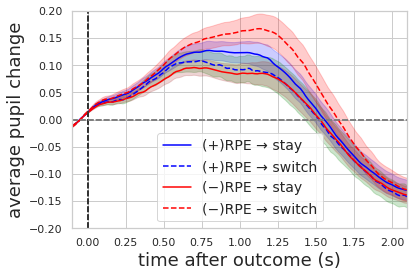

In [142]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['(+)RPE → stay', 
                      '(+)RPE → switch',
                      '(−)RPE → stay',
                      '(−)RPE → switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


#linecolor = ['blue', 'blue', 'red', 'red']
linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dashed', 'solid', 'dashed']

linecolor2 = ['blue', 'green', 'brown', 'red']


for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2, color=linecolor2[i])

#ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.2, 0.2])
ax4.set_xlim([-0.1, 2.1])
ax4.legend(prop={"size":14})
#plt.legend()
        

In [143]:
t_epochs['t_outcome'][(t_epochs['t_outcome'] >= 0.5) & (t_epochs['t_outcome'] <= 1.5)]

array([0.516295, 0.53295 , 0.549605, 0.566259, 0.582914, 0.599569,
       0.616223, 0.632878, 0.649533, 0.666187, 0.682842, 0.699497,
       0.716151, 0.732806, 0.749461, 0.766116, 0.78277 , 0.799425,
       0.81608 , 0.832734, 0.849389, 0.866044, 0.882698, 0.899353,
       0.916008, 0.932662, 0.949317, 0.965972, 0.982626, 0.999281,
       1.015936, 1.032591, 1.049245, 1.0659  , 1.082555, 1.099209,
       1.115864, 1.132519, 1.149173, 1.165828, 1.182483, 1.199137,
       1.215792, 1.232447, 1.249101, 1.265756, 1.282411, 1.299066,
       1.31572 , 1.332375, 1.34903 , 1.365684, 1.382339, 1.398994,
       1.415648, 1.432303, 1.448958, 1.465612, 1.482267, 1.498922])

(52, 4, 187)


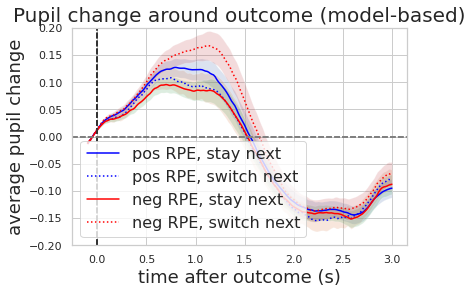

In [144]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['pos RPE, stay next', 
                      'pos RPE, switch next',
                      'neg RPE, stay next',
                      'neg RPE, switch next']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dotted', 'solid', 'dotted']
for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.2, 0.2])
ax4.legend(prop={"size":16})
#plt.legend()
        

(52, 4, 187)


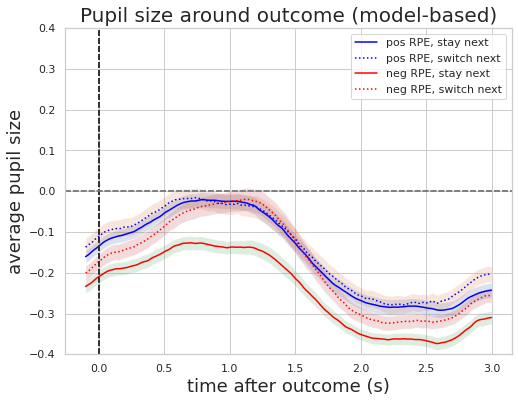

In [145]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['pos RPE, stay next', 
                      'pos RPE, switch next',
                      'neg RPE, stay next',
                      'neg RPE, switch next']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['RPE'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['RPE'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(8, 6))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dotted', 'solid', 'dotted']
for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
#ax4.set_ylim([-0.3, 0.3])
ax4.set_ylim([-0.4, 0.4])

ax4.legend(prop={"size":16})
plt.legend()
        

In [146]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

(52, 4, 187)


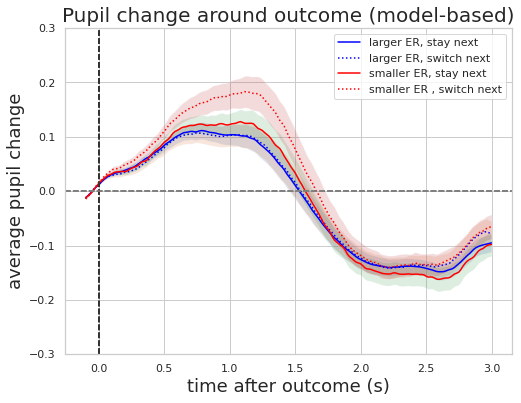

In [147]:
# plot the average for all subjects

types = 'switch_next'
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['larger ER, stay next', 
                      'larger ER, switch next',
                      'smaller ER, stay next',
                      'smaller ER , switch next']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['ER_diff_after'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['ER_diff_after'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['ER_diff_after'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['ER_diff_after'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(8, 6))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']


linecolor = ['blue', 'blue', 'red', 'red']
linetype = ['solid', 'dotted', 'solid', 'dotted']
for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i], linestyle=linetype[i], color=linecolor[i])
    ax4.axvline(x=0,color=".2", linestyle="--")
    ax4.axhline(y=0,color="grey", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event} (model-based)',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
#ax4.set_ylim([-0.35, 0.35])
ax4.set_ylim([-0.3, 0.3])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 4, 187)


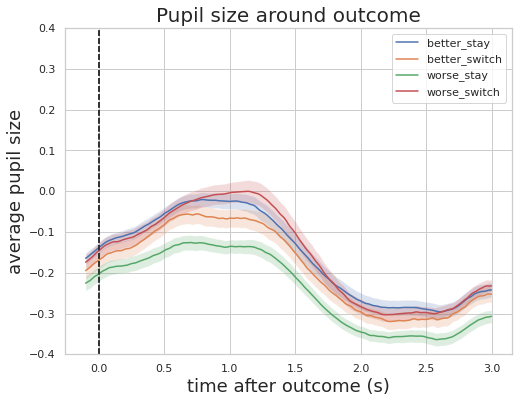

In [148]:
# plot the average for all subjects

types = 'switch_next'
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'
labels = ['better_stay', 
                      'better_switch',
                      'worse_stay',
                      'worse_switch']

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data_new = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
    to_plot11 = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]

    to_plot2 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] > 0)]
    to_plot22 = joint_data_new[(joint_data_new[types] == True) & (joint_data_new['outcome_change'] < 0)]


    
    Y = [to_plot1, to_plot2, to_plot11, to_plot22]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(8, 6))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=labels[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.4, 0.4])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


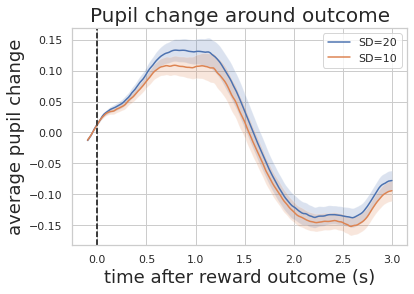

In [149]:
# plot the average for all subjects

types = ['SD=20', 'SD=10']
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[joint_data['SD'] == 20]
    to_plot2 = joint_data[joint_data['SD'] == 10]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil change',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
#ax4.set_ylim([-0.08, 0.08])
ax4.legend(prop={"size":16})
plt.legend()
        

(52, 2, 187)


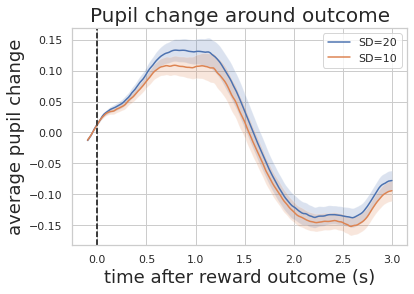

In [150]:
# plot the average for all subjects

types = ['SD=20', 'SD=10']
metric = 'change'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[joint_data_temp['free'] == True]

    
    
    to_plot1 = joint_data[joint_data['SD'] == 20]
    to_plot2 = joint_data[joint_data['SD'] == 10]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel('average pupil change',fontsize=18)
ax4.set_xlabel('time after reward outcome (s)',fontsize=18)
#ax4.set_ylim([-0.08, 0.08])
ax4.legend(prop={"size":16})
plt.legend()
        

In [151]:
# get the correlation

joint_data.head()

,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp,sess
4,4,4,4,0.886,"[0.2329468694457934, 0.2195645528616627, 0.246...","[1.7544874871463856, 1.7720780239957616, 1.805...","[0.8322483658106244, 0.8368113607088992, 0.775...",0.847741,"[0.8457479447273881, 0.872420260350685, 0.9672...",1.237052,...,0.367036,-0.067325,0.008532,-0.035290,True,False,71.0,1,0,1.0
5,5,5,5,0.524,"[1.604212964386441, 1.6285303725867817, 1.6628...","[0.7685031736132147, 0.8136426641189665, 0.859...","[1.6519808448121482, 1.6435078302662, 1.651376...",1.751446,"[1.7937574818611532, 1.7857466174736965, 1.757...",1.382578,...,-0.067325,-0.215412,-0.035290,-0.153870,False,False,-9.0,2,0,1.0
6,6,6,6,0.534,"[-0.6259594067889568, -0.580431477955717, -0.5...","[0.2999592623031137, 0.26569563391781836, 0.30...","[-0.02224315815839232, -0.04403337339354349, -...",0.359808,"[0.581052140277717, 0.6451061668589583, 0.6861...",0.913374,...,-0.215412,-0.385074,-0.153870,-0.246080,False,False,18.0,3,0,1.0
7,7,7,7,0.781,"[0.9413728981995821, 0.8963505792510152, 0.860...","[-0.398104164104001, -0.37839306728714694, -0....","[0.4901778384479871, 0.5030240859159255, 0.560...",0.872949,"[1.0477415953915061, 1.065030901711759, 1.0884...",0.338019,...,-0.385074,-0.436201,-0.246080,-0.245045,False,False,-12.0,4,0,1.0
8,8,8,8,1.291,"[0.5843384851342176, 0.5273335215865524, 0.478...","[-0.205693408226777, -0.2218313300040943, -0.2...","[0.5114205969271836, 0.5018882640692223, 0.536...",0.247190,"[0.05178672665339497, 0.03727946032023733, -0....",0.159929,...,-0.436201,-0.401825,-0.245045,-0.179503,False,False,-16.0,5,0,1.0


In [152]:
joint_data.keys()

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [153]:
joint_data[['rt', 'rt_next']]

,rt,rt_next
4,0.886,0.524
5,0.524,0.534
6,0.534,0.781
7,0.781,1.291
8,1.291,1.449
...,...,...
763,1.142,0.316
764,0.316,0.412
765,0.412,0.319
766,0.319,0.325


In [154]:
# joint all subjects together
joint_all_sub_data = pd.DataFrame()
pupil
for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    
    joint_all_sub_data = pd.concat([joint_all_sub_data, joint_data_temp], axis=0)
    
joint_all_sub_data.reset_index(drop=True, inplace=True)


In [155]:
joint_all_sub_data

,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp,sess
0,0,0,0,0.873,"[-0.13285487334831725, -0.15435727323074105, -...","[0.07491006887873684, 0.13786000971694218, 0.1...","[0.11437311041501608, 0.10994014858446984, 0.1...",0.279017,"[0.353667051165722, 0.39952404529320773, 0.433...",0.475576,...,0.000000,-0.117293,0.000000,0.000000,False,False,48.0,0,0,1.0
1,1,1,1,0.503,"[0.14530678606560862, 0.1443430154502174, 0.24...","[0.23190501894722576, 0.17961922205809192, 0.1...","[0.34474857188501473, 0.35575292963603705, 0.3...",0.299246,"[0.3427030080472347, 0.3527936049405821, 0.374...",1.147825,...,-0.117293,-0.143198,0.000000,0.000000,False,True,22.0,0,0,1.0
2,2,2,2,0.948,"[0.22792893919942742, 0.15482785060969537, 0.1...","[0.1730485920638111, 0.15684330963330576, 0.18...","[-0.5578585701312097, -0.5368051541620953, -0....",-0.249000,"[-0.043562563000114525, -0.010950897831385292,...",-0.182329,...,0.143198,-0.013064,0.000000,-0.006041,True,False,-20.0,0,0,1.0
3,3,3,3,0.633,"[-0.04115643605480424, -0.011971396588699315, ...","[-0.02837186777614119, 0.004751287527410095, 0...","[0.9398780279838435, 0.9354819044102489, 0.927...",0.780104,"[0.6531173173194468, 0.6612715975477902, 0.646...",0.399992,...,-0.013064,-0.420074,-0.006041,0.022409,False,False,50.0,0,0,1.0
4,4,4,4,1.754,"[0.7752312920948785, 0.8033788108457145, 0.831...","[0.467254551806917, 0.46196730826422516, 0.473...","[0.13627293908167493, 0.0938579818830942, 0.08...",-0.051292,"[-0.1988164400882881, -0.1855046140065632, -0....",0.438572,...,-0.420074,-0.341523,0.022409,-0.011922,False,False,-41.0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39738,91,91,91,1.142,"[0.67943674845904, 0.7272363341078137, 0.73705...","[0.5511960490811909, 0.5499120983188762, 0.581...","[1.0707077050777225, 1.0654853260524422, 1.070...",1.213163,"[1.3801842435307121, 1.323949527624748, 1.1854...",0.497171,...,-0.190555,-0.310069,0.002049,-0.193693,False,True,14.0,4,29,8.0
39739,92,92,92,0.316,"[-0.17780774209706132, -0.13794868236501812, -...","[-0.8800874249291134, -0.863458312754363, -0.8...","[-0.14873885096615147, -0.11531997069426185, -...",0.221271,"[0.32346568708713375, 0.35393766046567277, 0.4...",0.406316,...,0.310069,0.174400,0.193693,0.094960,True,False,17.0,5,30,8.0
39740,93,93,93,0.412,"[-1.203478368664157, -1.1643138433366318, -1.1...","[-3.327919441521653, -3.3458417071503943, -3.3...","[-1.1940200358695918, -1.1961699578124045, -1....",-1.551658,"[-1.7172245184480575, -1.7368905531884036, -1....",-2.623501,...,0.174400,-0.278061,0.094960,-0.209280,False,True,-18.0,6,31,8.0
39741,94,94,94,0.319,"[-1.6546526797253853, -1.6049083492062692, -1....","[-0.23448572896024178, -0.11422985799373579, -...","[-1.558495613955596, -1.5328490750914376, -1.4...",-1.222526,"[-1.106845834894351, -1.1308387794174326, -1.1...",-0.842620,...,0.278061,-0.185099,0.209280,-0.151476,True,True,-6.0,7,32,8.0


In [240]:
joint_all_sub_data.keys()
joint_data_new = joint_all_sub_data[(joint_all_sub_data['free']==True)  &  (joint_all_sub_data['trial_after_cp']<=5) & (joint_all_sub_data['trial_after_cp']>0)] # free trials only


In [241]:
df = joint_data_new[keys_to_include_psy]

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

#pvall = joint_selected.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
#pvall


,rt,pupil_change_avg_pre_response,pupil_change_avg_response,pupil_change_avg_outcome,pupil_change_avg_outcome1,pupil_change_avg_outcome3,pupil_size_avg_pre_response,pupil_size_avg_response,pupil_size_avg_outcome,RPE,...,outcomes,outcome_change,SD,changepoints,trial_after_forced,trial_after_cp,mean_A,mean_B,mean_chosen,mean_unchosen
rt,1.0***,0.1***,0.06***,-0.09***,-0.15***,-0.07***,0.14***,0.14***,0.1***,0.02,...,0.01,-0.01,0.01,-0.04*,-0.09***,-0.02,0.01,0.07***,0.03,0.05**
pupil_change_avg_pre_response,0.1***,1.0***,0.65***,-0.05**,-0.11***,-0.03,0.25***,0.22***,0.11***,-0.01,...,-0.02,-0.02,-0.01,-0.0,-0.03,0.01,-0.01,0.0,-0.01,0.01
pupil_change_avg_response,0.06***,0.65***,1.0***,-0.2***,-0.32***,-0.14***,-0.13***,0.24***,0.24***,-0.0,...,0.0,-0.01,0.0,0.02,-0.05***,-0.01,0.05**,0.02,0.01,0.06***
pupil_change_avg_outcome,-0.09***,-0.05**,-0.2***,1.0***,0.58***,0.82***,-0.23***,-0.37***,0.11***,-0.05**,...,-0.05**,-0.02,-0.01,0.04*,0.03*,-0.05**,-0.03*,-0.03,-0.05**,-0.01
pupil_change_avg_outcome1,-0.15***,-0.11***,-0.32***,0.58***,1.0***,0.43***,-0.62***,-0.85***,-0.72***,-0.05**,...,-0.04*,-0.02,0.0,0.06***,0.1***,-0.06***,-0.01,-0.08***,-0.03*,-0.06***
pupil_change_avg_outcome3,-0.07***,-0.03,-0.14***,0.82***,0.43***,1.0***,-0.16***,-0.26***,0.1***,-0.07***,...,-0.07***,-0.04**,-0.01,0.03,0.02,-0.05**,-0.03,-0.01,-0.05**,0.01
pupil_size_avg_pre_response,0.14***,0.25***,-0.13***,-0.23***,-0.62***,-0.16***,1.0***,0.86***,0.58***,0.06***,...,0.04*,0.03,-0.02,-0.09***,-0.08***,0.08***,-0.04*,0.09***,0.03,0.02
pupil_size_avg_response,0.14***,0.22***,0.24***,-0.37***,-0.85***,-0.26***,0.86***,1.0***,0.75***,0.06***,...,0.05**,0.04*,-0.01,-0.08***,-0.11***,0.08***,-0.0,0.11***,0.05**,0.06***
pupil_size_avg_outcome,0.1***,0.11***,0.24***,0.11***,-0.72***,0.1***,0.58***,0.75***,1.0***,0.02,...,0.01,0.02,-0.01,-0.05***,-0.1***,0.04*,-0.02,0.08***,0.0,0.06***
RPE,0.02,-0.01,-0.0,-0.05**,-0.05**,-0.07***,0.06***,0.06***,0.02,1.0***,...,0.89***,0.81***,-0.02,-0.23***,0.09***,0.27***,0.21***,0.24***,0.57***,-0.15***


In [245]:
keys_to_include_psy = [#'mean_score_free', 'p_stay', 'p_better_stay', 'p_worse_stay', \
                    #'l-to-h-minus-h-to-l_free', 'l-to-h-minus-h-to-l_forced', 'l-to-h-minus-h-to-l_all', \
                         'rt',
    'pupil_change_avg_pre_response',
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       #'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2','pupil_change_avg_outcome_nassar', 'pupil_change_avg_outcome3',
    'pupil_change_avg_outcome','pupil_change_avg_outcome1', 'pupil_change_avg_outcome3',
       'pupil_size_avg_pre_response', 
        'pupil_size_avg_response', 
       'pupil_size_avg_outcome', 'RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after',
       
       
        'switch', 'switch_next',
           'outcomes','outcome_change', 
       #'forced', 'free',
       'SD', 'changepoints', 'trial_after_forced', 'trial_after_cp',# 'sess','trial',
'mean_A', 'mean_B', 'mean_chosen', 'mean_unchosen', ]

key_to_plot = 'pupil_change_avg_outcome1'

from scipy.stats import pearsonr

rt_list = pd.DataFrame()
pval_list = pd.DataFrame()

for sub in valid_sub-1:
    joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
    joint_data = joint_data_temp[(joint_data_temp['free']==True)  & (joint_data_temp['changepoints']==True)] # free trials only
    #oint_data = joint_data_temp
    df = joint_data[keys_to_include_psy]

    rho = df.corr()
    pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    
    rt_list[f'sub{sub+1}'] = rho[key_to_plot]
    pval_list[f'sub{sub+1}'] = pval[key_to_plot]
    #p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    #rho.round(2).astype(str) + p

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlat

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlat

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome1 (free)')

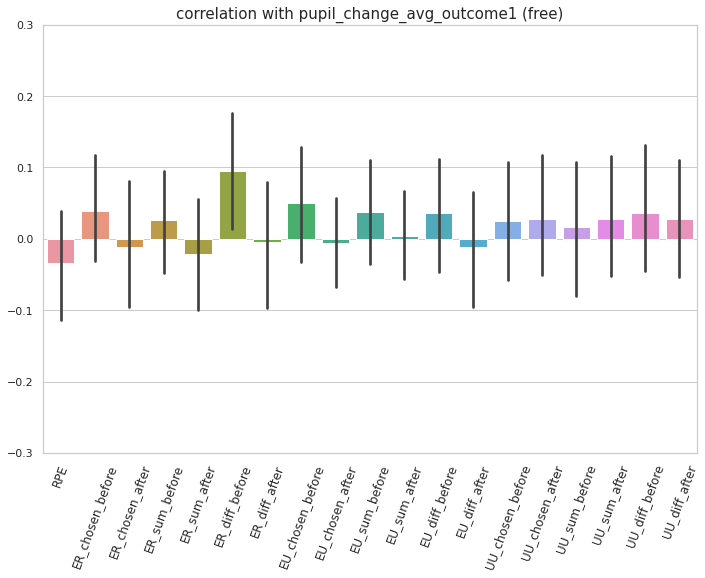

In [246]:

tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free)', fontsize=15)


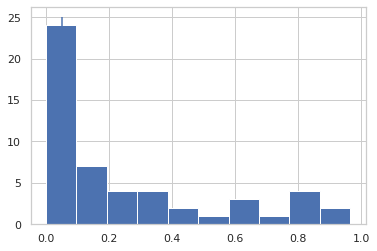

In [224]:
plt.hist(pval_list.T['UU_sum_after'])
plt.vlines(0.05, ymin=0, ymax=25)

In [225]:
stats.ttest_1samp(pval_list.T['UU_sum_after'], 0.05)

Ttest_1sampResult(statistic=4.738913805558138, pvalue=1.7600079671744863e-05)

In [247]:
rt_list.mean(axis=1)


rt                              -0.130170
pupil_change_avg_pre_response   -0.149316
pupil_change_avg_response       -0.324729
pupil_change_avg_outcome         0.594033
pupil_change_avg_outcome1        1.000000
pupil_change_avg_outcome3        0.458591
pupil_size_avg_pre_response     -0.599537
pupil_size_avg_response         -0.847390
pupil_size_avg_outcome          -0.718171
RPE                             -0.034336
ER_chosen_before                 0.038657
ER_chosen_after                 -0.011850
ER_sum_before                    0.025696
ER_sum_after                    -0.021586
ER_diff_before                   0.094575
ER_diff_after                   -0.004742
EU_chosen_before                 0.050099
EU_chosen_after                 -0.005195
EU_sum_before                    0.037120
EU_sum_after                     0.004156
EU_diff_before                   0.036634
EU_diff_after                   -0.012057
UU_chosen_before                 0.024874
UU_chosen_after                  0

In [249]:
pval_list.T.mean()

rt                               0.423723
pupil_change_avg_pre_response    0.427594
pupil_change_avg_response        0.263900
pupil_change_avg_outcome         0.113491
pupil_change_avg_outcome1        0.000000
pupil_change_avg_outcome3        0.185850
pupil_size_avg_pre_response      0.125395
pupil_size_avg_response          0.008633
pupil_size_avg_outcome           0.064612
RPE                              0.528408
ER_chosen_before                 0.514846
ER_chosen_after                  0.457679
ER_sum_before                    0.557192
ER_sum_after                     0.540404
ER_diff_before                   0.421303
ER_diff_after                    0.474953
EU_chosen_before                 0.504534
EU_chosen_after                  0.573646
EU_sum_before                    0.551412
EU_sum_after                     0.584928
EU_diff_before                   0.479003
EU_diff_after                    0.471405
UU_chosen_before                 0.479091
UU_chosen_after                  0

In [212]:
rt_list.T

,rt,pupil_change_avg_pre_response,pupil_change_avg_response,pupil_change_avg_outcome,pupil_change_avg_outcome1,pupil_change_avg_outcome3,pupil_size_avg_pre_response,pupil_size_avg_response,pupil_size_avg_outcome,RPE,...,outcomes,outcome_change,SD,changepoints,trial_after_forced,trial_after_cp,mean_A,mean_B,mean_chosen,mean_unchosen
sub1,0.009924,-0.117116,-0.328765,0.555923,1.0,0.394328,-0.478080,-0.794621,-0.617823,-0.029544,...,-0.009216,-0.039330,-0.052292,0.072074,-0.043770,0.045981,-0.009826,-0.014187,-0.014101,-0.010465
sub2,-0.040197,-0.183304,-0.457408,0.780388,1.0,0.604688,-0.293037,-0.635918,-0.434212,0.129175,...,0.145051,0.109765,0.102251,-0.108463,-0.075934,-0.028980,0.238275,-0.069324,0.074942,0.105500
sub3,-0.287494,0.071346,-0.141477,0.529116,1.0,0.350183,-0.649907,-0.837619,-0.701606,-0.044621,...,-0.060497,0.008589,0.083950,0.198796,0.056993,0.270829,-0.080825,-0.163459,-0.123149,-0.135223
sub4,-0.271485,-0.224238,-0.358966,0.602922,1.0,0.514223,-0.667947,-0.874601,-0.807173,-0.061248,...,-0.042900,-0.075779,0.078325,0.055796,0.081387,0.013643,0.021318,-0.063572,0.016903,-0.060776
sub6,-0.152692,-0.075281,-0.243390,0.489420,1.0,0.432726,-0.675369,-0.903126,-0.781155,-0.058557,...,-0.075651,-0.008945,0.122103,0.114610,-0.034025,0.247664,0.069852,-0.048134,-0.006602,0.032379
sub8,-0.110299,-0.213749,-0.372709,0.502417,1.0,0.356703,-0.709992,-0.888195,-0.781193,-0.099469,...,-0.222435,-0.109468,0.009632,0.233189,0.070455,0.188040,-0.262586,-0.243910,-0.288658,-0.245834
sub10,-0.113391,-0.153139,-0.328617,0.533300,1.0,0.501482,-0.811753,-0.938819,-0.844291,-0.019125,...,-0.123409,0.073906,-0.028274,0.150404,0.020534,0.183859,-0.261448,-0.156809,-0.184097,-0.238219
sub11,-0.112685,-0.147572,-0.288333,0.682417,1.0,0.447137,-0.529212,-0.816277,-0.602464,-0.062890,...,-0.049506,-0.034039,-0.046988,0.030000,0.191019,0.065287,0.059468,0.025850,0.042081,0.042951
sub12,-0.289102,-0.077256,-0.339932,0.430031,1.0,0.257454,-0.779375,-0.894166,-0.874432,-0.107354,...,-0.210601,-0.023797,0.194442,0.167094,0.116115,0.259690,-0.289624,0.067750,-0.215929,-0.010070
sub13,-0.047531,-0.036584,-0.405393,0.666324,1.0,0.434791,-0.497195,-0.838470,-0.563672,-0.069860,...,-0.090901,-0.016867,0.027137,0.038718,0.034340,-0.092075,-0.104939,-0.103204,-0.105366,-0.103007


In [220]:
stats.ttest_1samp(rt_list.T['UU_sum_after'], 0)

Ttest_1sampResult(statistic=7.697923731486692, pvalue=4.3215498690358943e-10)

In [200]:
to_plot_tr.mean()

RPE                -0.062450
ER_chosen_before   -0.052975
ER_chosen_after    -0.084261
ER_sum_before      -0.073810
ER_sum_after       -0.096261
ER_diff_before      0.005121
ER_diff_after      -0.045540
EU_chosen_before    0.042658
EU_chosen_after     0.083736
EU_sum_before       0.068337
EU_sum_after        0.089031
EU_diff_before      0.002541
EU_diff_after       0.047487
UU_chosen_before    0.042789
UU_chosen_after     0.100757
UU_sum_before       0.066704
UU_sum_after        0.108920
UU_diff_before     -0.004232
UU_diff_after       0.076674
dtype: float64

In [163]:
print(key_to_plot)
pval_list.T[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

pupil_change_avg_outcome


,RPE,ER_chosen_before,ER_chosen_after,ER_sum_before,ER_sum_after,ER_diff_before,ER_diff_after,EU_chosen_before,EU_chosen_after,EU_sum_before,EU_sum_after,EU_diff_before,EU_diff_after,UU_chosen_before,UU_chosen_after,UU_sum_before,UU_sum_after,UU_diff_before,UU_diff_after
sub1,0.330064,0.047366,0.237727,0.145978,0.294127,0.096965,0.287521,0.349910,0.620553,0.979469,0.880150,0.219306,0.311895,0.280877,0.516018,0.487405,0.515232,0.399037,0.588147
sub2,0.674423,0.920456,0.629398,0.297401,0.700162,0.240627,0.177033,0.841128,0.646118,0.653973,0.420869,0.501475,0.896182,0.798150,0.586480,0.387577,0.264513,0.624731,0.874569
sub3,0.397318,0.408837,0.865262,0.531076,0.875509,0.421742,0.878709,0.938617,0.345280,0.913714,0.433478,0.987855,0.476229,0.860258,0.391071,0.562296,0.147090,0.798892,0.832520
sub4,0.941077,0.115047,0.139046,0.147017,0.148820,0.278049,0.254471,0.863733,0.099690,0.802654,0.230386,0.982265,0.151694,0.420137,0.767841,0.467128,0.884512,0.558584,0.680500
sub6,0.872053,0.579463,0.492856,0.988899,0.610264,0.332721,0.395819,0.219533,0.397225,0.004233,0.205326,0.975212,0.728887,0.333308,0.024319,0.021539,0.005824,0.592395,0.101603
sub8,0.634402,0.967185,0.608728,0.472738,0.741599,0.295018,0.177997,0.652764,0.391415,0.169848,0.108022,0.390655,0.629081,0.738513,0.031109,0.647589,0.031283,0.947144,0.057673
sub10,0.000038,0.758213,0.013386,0.113077,0.210785,0.214566,0.000779,0.051990,0.631195,0.400740,0.865132,0.055443,0.316386,0.841270,0.759318,0.588410,0.619047,0.397823,0.928620
sub11,0.489451,0.053071,0.049515,0.052283,0.035503,0.518096,0.203474,0.941145,0.996372,0.050112,0.190761,0.088878,0.115445,0.154375,0.054586,0.025667,0.003119,0.887587,0.536522
sub12,0.552280,0.263462,0.681832,0.687714,0.940928,0.065215,0.423844,0.849184,0.589163,0.950233,0.720862,0.835273,0.593268,0.695946,0.292320,0.874396,0.499478,0.680769,0.206894
sub13,0.176395,0.080071,0.831531,0.437611,0.713458,0.113766,0.973298,0.196904,0.910742,0.300246,0.955157,0.425961,0.879593,0.412835,0.816812,0.088685,0.650722,0.585920,0.374175


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome (free)')

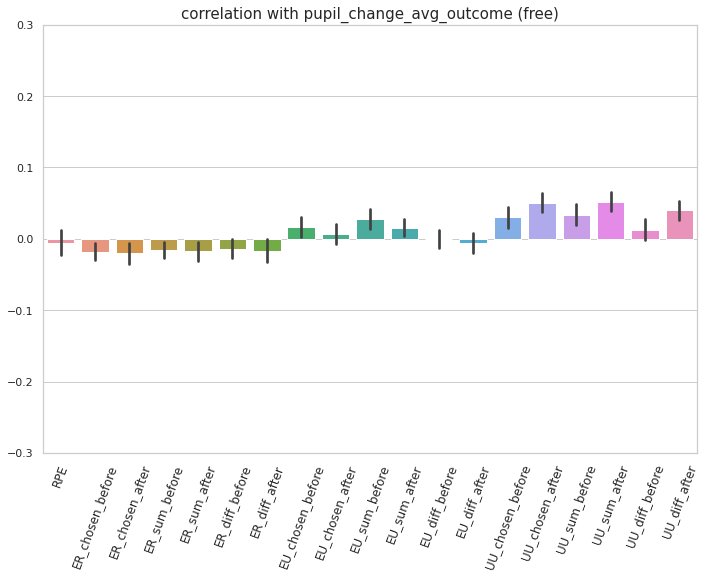

In [164]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free)', fontsize=15)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome (free)')

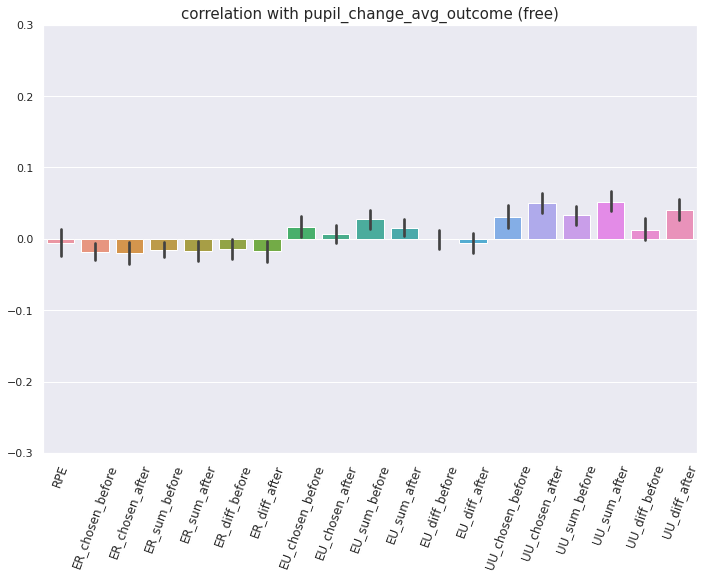

In [88]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free)', fontsize=15)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome3 (free)')

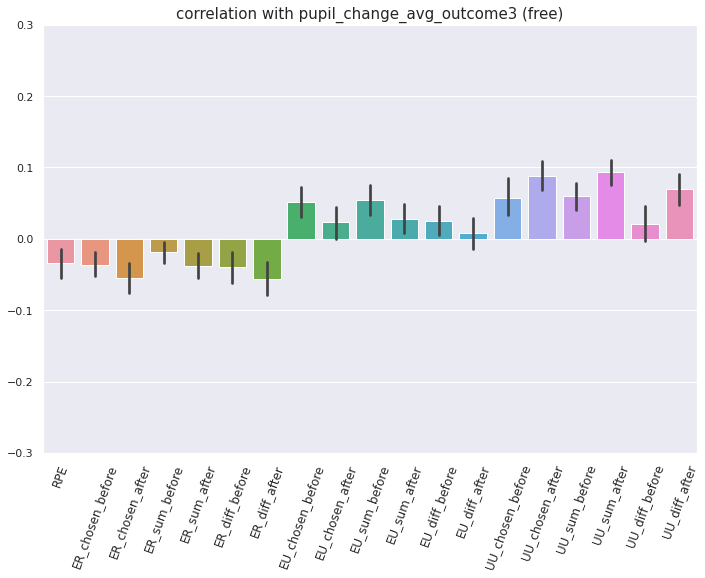

In [68]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free)', fontsize=15)

In [51]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome_nassar', 'pupil_change_avg_outcome3',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']]

In [52]:
tr_list_reversed.head()

,rt,pupil_change_avg_pre_response,pupil_change_avg_response,pupil_change_avg_outcome,pupil_change_avg_outcome_nassar,pupil_change_avg_outcome3,pupil_size_avg_pre_response,pupil_size_avg_response,pupil_size_avg_outcome,RPE,...,outcomes,outcome_change,SD,changepoints,trial_after_forced,trial_after_cp,mean_A,mean_B,mean_chosen,mean_unchosen
sub1,-0.151463,1.0,0.486793,-0.014981,-0.014599,-0.004992,0.238558,0.205810,0.109062,-0.038462,...,-0.006054,-0.027393,-0.041324,-0.100454,-0.087784,0.073755,0.022881,0.074826,0.055381,0.044481
sub2,0.345479,1.0,0.661415,0.008259,-0.054078,0.022592,0.508882,0.463201,0.343775,-0.018222,...,-0.029242,-0.045282,0.183135,0.046120,0.000178,-0.022992,0.079605,-0.132736,-0.002238,-0.045639
sub3,-0.070925,1.0,0.492986,0.023384,-0.043299,0.060224,0.120645,0.025220,-0.042721,0.027236,...,0.065043,0.105108,0.049823,-0.019703,0.009566,-0.013548,-0.023756,0.015249,0.062724,-0.074150
sub4,0.240698,1.0,0.673544,-0.048197,-0.021647,-0.035453,0.246411,0.300938,0.236954,-0.043852,...,-0.030911,0.055241,-0.095646,-0.029573,-0.089874,-0.131824,0.073137,0.052123,0.028846,0.102525
sub6,-0.028516,1.0,0.515314,0.015211,0.079324,0.049962,0.195497,0.169969,0.083731,-0.006347,...,0.012911,-0.041063,-0.012334,-0.117742,0.000835,0.033829,0.118234,-0.008509,0.019431,0.096277



gridsize = (1,1)
fig = plt.figure(figsize=(15, 10))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=15)
plt.ylim([-.3,0.3])
plt.tight_layout()

Text(0.5, 1.0, 'free trials')

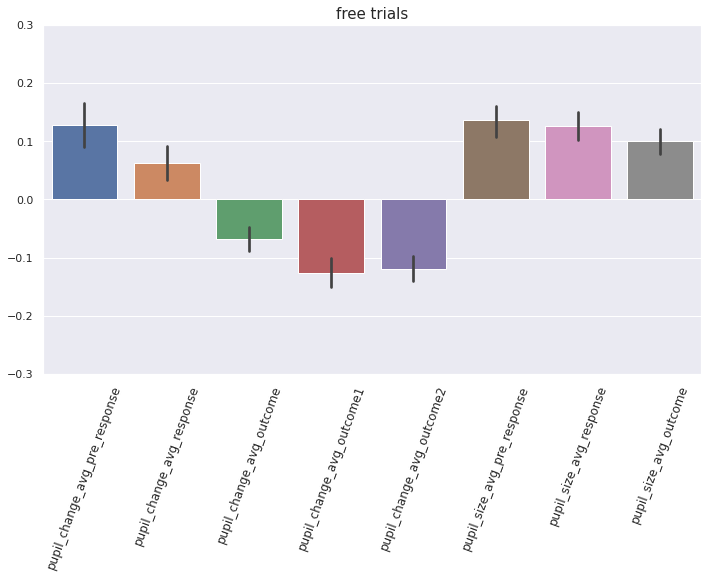

In [86]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title('free trials', fontsize=15)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'free trials, correlation with rt')

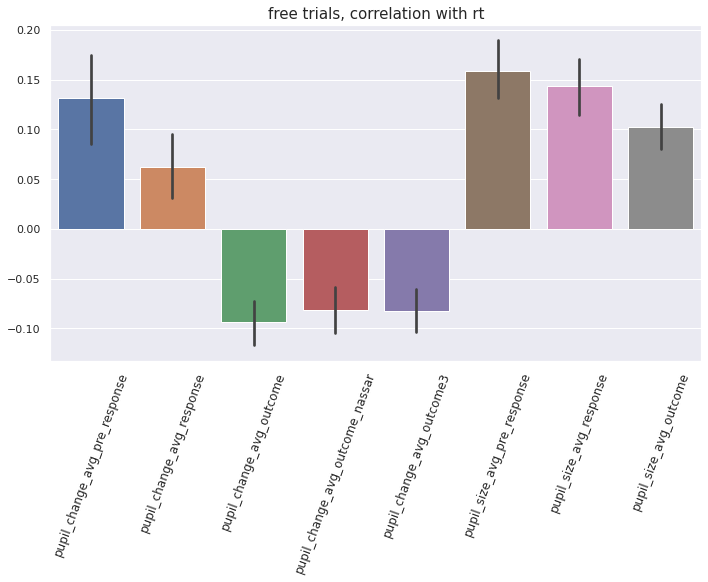

In [62]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome_nassar', 'pupil_change_avg_outcome3',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
#plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'free trials, correlation with {key_to_plot}', fontsize=15)

Text(0.5, 1.0, 'correlation with pupil_change_avg_outcome1 (free trials, <=5 trials after cp)')

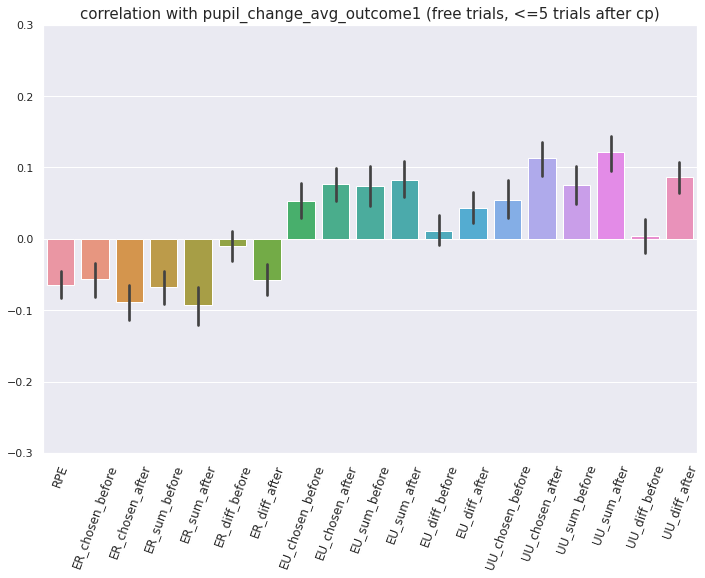

In [183]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[['RPE', 
    'ER_chosen_before','ER_chosen_after', 'ER_sum_before', 'ER_sum_after','ER_diff_before', 'ER_diff_after',
    'EU_chosen_before', 'EU_chosen_after','EU_sum_before', 'EU_sum_after', 'EU_diff_before', 'EU_diff_after',
    'UU_chosen_before', 'UU_chosen_after',  'UU_sum_before', 'UU_sum_after','UU_diff_before', 'UU_diff_after']]

#tr_list_reversed = rt_list.T
#to_plot_tr = tr_list_reversed[['pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']]
gridsize = (1,1)
fig = plt.figure(figsize=(10, 8))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=12)
plt.ylim([-.3,0.3])
plt.tight_layout()
plt.title(f'correlation with {key_to_plot} (free trials, <=5 trials after cp)', fontsize=15)

In [87]:
pval_to_plot = pval_list.T[['pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']]
pval_to_plot.mean()

pupil_change_avg_pre_response    0.095479
pupil_change_avg_response        0.131292
pupil_change_avg_outcome         0.238635
pupil_change_avg_outcome1        0.130798
pupil_change_avg_outcome2        0.156011
pupil_size_avg_pre_response      0.131510
pupil_size_avg_response          0.144037
pupil_size_avg_outcome           0.177220
dtype: float64

In [89]:
import numpy as np
from scipy import stats

for i in range(len(to_plot_tr.columns)):
    to_ttest = to_plot_tr[to_plot_tr.columns[i]]
    ss, pp = stats.ttest_1samp(to_ttest, popmean=0)
    print(pp)

6.786616825268175e-08
0.00040262533162803096
2.5080295986600712e-08
9.837510448293294e-15
5.0888945704937343e-14
1.2156574062609028e-12
7.728677349154862e-14
1.1673759480646024e-12


In [62]:
rt_list.T.head()

,rt,pupil_change_avg_pre_response,pupil_change_avg_response,pupil_change_avg_outcome,pupil_size_avg_pre_response,pupil_size_avg_response,pupil_size_avg_outcome,RPE,ER_chosen_before,ER_chosen_after,...,outcomes,outcome_change,SD,changepoints,trial_after_forced,trial_after_cp,mean_A,mean_B,mean_chosen,mean_unchosen
sub1,1.0,0.113628,-0.032447,-0.028779,0.115216,0.045970,0.027020,0.016693,-0.131794,-0.071511,...,-0.052122,-0.015988,-0.022640,-0.043332,-0.222970,0.010722,0.028606,-0.044174,-0.086364,0.070359
sub2,1.0,0.094841,-0.012108,0.000830,0.214720,0.172041,0.160425,0.026515,-0.035884,-0.028450,...,0.005034,-0.007562,0.054110,-0.001463,-0.127293,-0.061609,0.050805,-0.011147,-0.023996,0.061253
sub3,1.0,0.088718,-0.075655,-0.092255,0.343112,0.310364,0.289957,0.057896,-0.044352,0.001277,...,0.026203,0.037448,-0.004693,-0.034477,-0.234758,-0.042358,0.045377,0.077391,-0.024949,0.150908
sub4,1.0,0.019421,0.060390,-0.032432,0.130201,0.170373,0.195668,0.049985,-0.097206,-0.049273,...,-0.009072,0.060529,0.016155,-0.045772,-0.050325,-0.010375,0.034556,-0.006860,-0.052068,0.078324
sub6,1.0,-0.070576,-0.074142,-0.074925,0.122834,0.117858,0.092531,0.044382,-0.071563,-0.009251,...,0.005957,0.065675,0.009682,0.090027,-0.075951,0.018766,-0.018196,0.000914,-0.015322,-0.000882


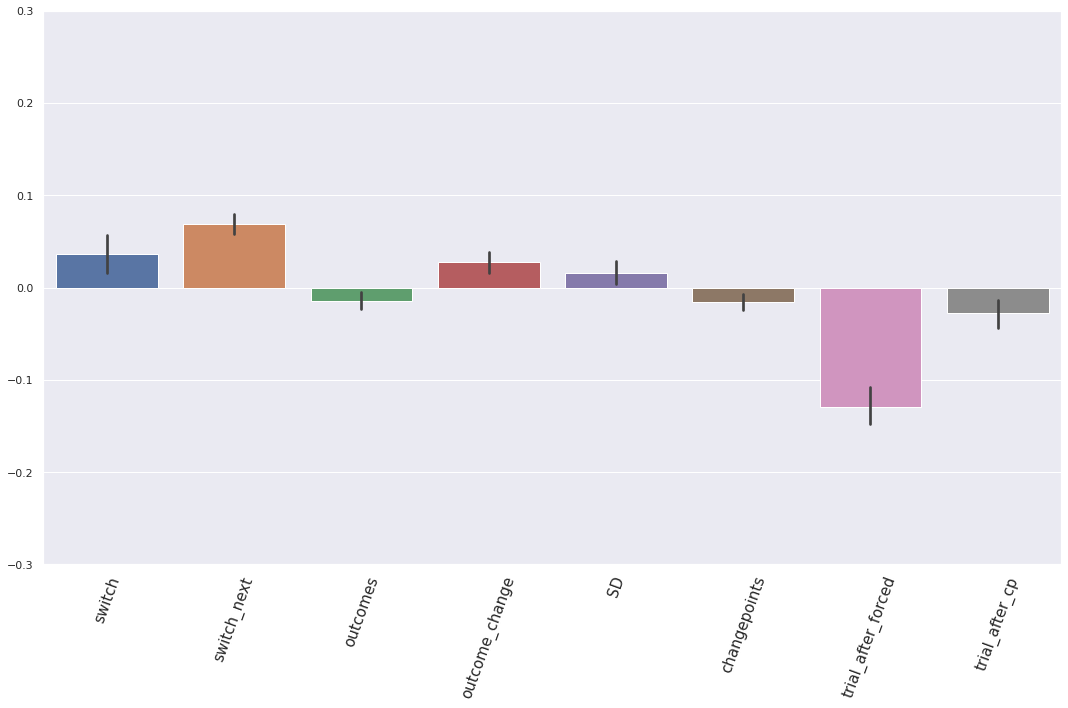

In [61]:
tr_list_reversed = rt_list.T
to_plot_tr = tr_list_reversed[[   
        'switch', 'switch_next',
           'outcomes','outcome_change', 
       #'forced', 'free',
       'SD', 'changepoints', 'trial_after_forced', 'trial_after_cp']]#,
#'mean_A', 'mean_B', 'mean_chosen', 'mean_unchosen',]]


gridsize = (1,1)
fig = plt.figure(figsize=(15, 10))
ax4
sns.barplot(data = to_plot_tr)

plt.xticks(rotation=70, fontsize=15)
plt.ylim([-.3,0.3])
plt.tight_layout()

### Find individual averages

In [90]:
joint_data_by_sub['sub1'].head()

,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp,sess
0,0,0,0,0.873,"[-0.13285487334831725, -0.15435727323074105, -...","[0.07491006887873684, 0.13786000971694218, 0.1...","[0.11437311041501608, 0.10994014858446984, 0.1...",0.279017,"[0.353667051165722, 0.39952404529320773, 0.433...",0.475576,...,0.000000,-0.117293,0.000000,0.000000,False,False,48.0,0,0,1.0
1,1,1,1,0.503,"[0.14530678606560862, 0.1443430154502174, 0.24...","[0.23190501894722576, 0.17961922205809192, 0.1...","[0.34474857188501473, 0.35575292963603705, 0.3...",0.299246,"[0.3427030080472347, 0.3527936049405821, 0.374...",1.147825,...,-0.117293,-0.143198,0.000000,0.000000,False,True,22.0,0,0,1.0
2,2,2,2,0.948,"[0.22792893919942742, 0.15482785060969537, 0.1...","[0.1730485920638111, 0.15684330963330576, 0.18...","[-0.5578585701312097, -0.5368051541620953, -0....",-0.249000,"[-0.043562563000114525, -0.010950897831385292,...",-0.182329,...,0.143198,-0.013064,0.000000,-0.006041,True,False,-20.0,0,0,1.0
3,3,3,3,0.633,"[-0.04115643605480424, -0.011971396588699315, ...","[-0.02837186777614119, 0.004751287527410095, 0...","[0.9398780279838435, 0.9354819044102489, 0.927...",0.780104,"[0.6531173173194468, 0.6612715975477902, 0.646...",0.399992,...,-0.013064,-0.420074,-0.006041,0.022409,False,False,50.0,0,0,1.0
4,4,4,4,1.754,"[0.7752312920948785, 0.8033788108457145, 0.831...","[0.467254551806917, 0.46196730826422516, 0.473...","[0.13627293908167493, 0.0938579818830942, 0.08...",-0.051292,"[-0.1988164400882881, -0.1855046140065632, -0....",0.438572,...,-0.420074,-0.341523,0.022409,-0.011922,False,False,-41.0,1,0,1.0


In [91]:
joint_data_by_sub['sub1'].columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_s

In [92]:
joint_data_temp[['pupil_size_avg_pre_response', 'pupil_change_avg_pre_response']].mean().to_numpy()

array([-0.05440561,  0.06757444])

In [93]:
joint_data_new

,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp,sess
4,4,4,4,0.886,"[0.2329468694457934, 0.2195645528616627, 0.246...","[1.7544874871463856, 1.7720780239957616, 1.805...","[0.8322483658106244, 0.8368113607088992, 0.775...",0.847741,"[0.8457479447273881, 0.872420260350685, 0.9672...",1.237052,...,0.367036,-0.067325,0.008532,-0.035290,True,False,71.0,1,0,1.0
5,5,5,5,0.524,"[1.604212964386441, 1.6285303725867817, 1.6628...","[0.7685031736132147, 0.8136426641189665, 0.859...","[1.6519808448121482, 1.6435078302662, 1.651376...",1.751446,"[1.7937574818611532, 1.7857466174736965, 1.757...",1.382578,...,-0.067325,-0.215412,-0.035290,-0.153870,False,False,-9.0,2,0,1.0
6,6,6,6,0.534,"[-0.6259594067889568, -0.580431477955717, -0.5...","[0.2999592623031137, 0.26569563391781836, 0.30...","[-0.02224315815839232, -0.04403337339354349, -...",0.359808,"[0.581052140277717, 0.6451061668589583, 0.6861...",0.913374,...,-0.215412,-0.385074,-0.153870,-0.246080,False,False,18.0,3,0,1.0
7,7,7,7,0.781,"[0.9413728981995821, 0.8963505792510152, 0.860...","[-0.398104164104001, -0.37839306728714694, -0....","[0.4901778384479871, 0.5030240859159255, 0.560...",0.872949,"[1.0477415953915061, 1.065030901711759, 1.0884...",0.338019,...,-0.385074,-0.436201,-0.246080,-0.245045,False,False,-12.0,4,0,1.0
8,8,8,8,1.291,"[0.5843384851342176, 0.5273335215865524, 0.478...","[-0.205693408226777, -0.2218313300040943, -0.2...","[0.5114205969271836, 0.5018882640692223, 0.536...",0.247190,"[0.05178672665339497, 0.03727946032023733, -0....",0.159929,...,-0.436201,-0.401825,-0.245045,-0.179503,False,False,-16.0,5,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,91,91,91,1.142,"[0.67943674845904, 0.7272363341078137, 0.73705...","[0.5511960490811909, 0.5499120983188762, 0.581...","[1.0707077050777225, 1.0654853260524422, 1.070...",1.213163,"[1.3801842435307121, 1.323949527624748, 1.1854...",0.497171,...,-0.190555,-0.310069,0.002049,-0.193693,False,True,14.0,4,29,8.0
764,92,92,92,0.316,"[-0.17780774209706132, -0.13794868236501812, -...","[-0.8800874249291134, -0.863458312754363, -0.8...","[-0.14873885096615147, -0.11531997069426185, -...",0.221271,"[0.32346568708713375, 0.35393766046567277, 0.4...",0.406316,...,0.310069,0.174400,0.193693,0.094960,True,False,17.0,5,30,8.0
765,93,93,93,0.412,"[-1.203478368664157, -1.1643138433366318, -1.1...","[-3.327919441521653, -3.3458417071503943, -3.3...","[-1.1940200358695918, -1.1961699578124045, -1....",-1.551658,"[-1.7172245184480575, -1.7368905531884036, -1....",-2.623501,...,0.174400,-0.278061,0.094960,-0.209280,False,True,-18.0,6,31,8.0
766,94,94,94,0.319,"[-1.6546526797253853, -1.6049083492062692, -1....","[-0.23448572896024178, -0.11422985799373579, -...","[-1.558495613955596, -1.5328490750914376, -1.4...",-1.222526,"[-1.106845834894351, -1.1308387794174326, -1.1...",-0.842620,...,0.278061,-0.185099,0.209280,-0.151476,True,True,-6.0,7,32,8.0


In [204]:
ind_avg_data = pd.DataFrame()


columns_to_include = ['rt','pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome']

for sub in valid_sub-1:
        # all trials
        joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
        avg_data = joint_data_temp[columns_to_include].mean()
        
        
        # all free / forced trials
        joint_data_free = joint_data_temp[joint_data_temp['free'] == True]
        joint_data_forced = joint_data_temp[joint_data_temp['forced'] == True]
        
        avg_data_free = joint_data_free[columns_to_include].mean()
        avg_data_forced = joint_data_forced[columns_to_include].mean()
        
        # all free, better vs. worse, switch vs. stay
        joint_data_new = joint_data_free
        better_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
        worse_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]
        better_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new['outcome_change'] > 0)]
        worse_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new['outcome_change'] < 0)]

        avg_data_better_switch = better_switch[columns_to_include].mean()
        avg_data_worse_switch = worse_switch[columns_to_include].mean()
        avg_data_better_stay = better_stay[columns_to_include].mean()
        avg_data_worse_stay = worse_stay[columns_to_include].mean()


        ###### TODO: decide the trial types
        avg_data_diff = avg_data_better_stay - avg_data_better_switch
        ind_avg_data = pd.concat([ind_avg_data, avg_data_diff], axis=1)

    

ind_avg_data = ind_avg_data.T
ind_avg_data.reset_index(inplace=True)
ind_avg_data.insert(0, 'sub', valid_sub)

In [205]:
ind_avg_data.T

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
sub,1.000000,2.000000,3.000000,4.000000,6.000000,8.000000,10.000000,11.000000,12.000000,13.000000,...,51.000000,52.000000,53.000000,54.000000,55.000000,56.000000,57.000000,58.000000,59.000000,60.000000
index,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rt,0.030449,0.126715,0.028737,0.331889,0.260968,-0.018348,-0.044044,-0.015142,0.268425,0.034093,...,0.104980,0.076747,-0.005897,0.073537,0.061891,-0.058442,-0.042477,-0.085926,0.098612,0.026956
pupil_change_avg_pre_response,-0.015454,-0.126198,0.010721,-0.120882,-0.108525,0.000161,-0.002865,-0.086017,0.052447,-0.009385,...,-0.035483,0.009271,0.100789,-0.073021,0.132982,-0.004847,-0.076085,-0.054416,-0.034263,-0.029666
pupil_change_avg_response,-0.002381,-0.154674,-0.076814,-0.082769,-0.139340,0.058101,0.042060,-0.103758,0.047525,0.045022,...,-0.002402,0.091780,0.112603,-0.142275,0.137380,-0.005542,-0.034475,-0.147172,-0.058268,0.027030
pupil_change_avg_outcome,0.043905,-0.168458,-0.123510,-0.165871,-0.056570,0.133304,0.011471,-0.032514,-0.006627,0.034584,...,0.162375,0.236150,0.097785,0.012494,0.182732,0.113113,-0.099506,0.026202,-0.049904,-0.007801
pupil_size_avg_pre_response,-0.196080,-0.035413,0.120021,-0.034949,0.003193,0.015896,-0.298950,-0.105770,-0.105059,-0.094323,...,-0.262008,-0.116145,-0.000267,-0.145403,0.040792,-0.109890,-0.037870,-0.277228,-0.006690,-0.148466
pupil_size_avg_response,-0.183007,-0.063889,0.032486,0.003164,-0.027622,0.073837,-0.254025,-0.123512,-0.109981,-0.039916,...,-0.228927,-0.033637,0.011547,-0.214656,0.045190,-0.110585,0.003740,-0.369984,-0.030694,-0.091770
pupil_size_avg_outcome,-0.136721,-0.077673,-0.014210,-0.079939,0.055149,0.149039,-0.284613,-0.052268,-0.164133,-0.050354,...,-0.064150,0.110734,-0.003271,-0.059887,0.090542,0.008070,-0.061291,-0.196610,-0.022331,-0.126600


In [206]:
#ind_avg_data

In [108]:
# import psychiatric data

psychiatric_data = pd.read_csv('psychiatric_data_use.csv')
psychiatric_data

,Unnamed: 0,Subj number,WFRIS_family,WFRIS_work,WFRIS_school,WFRIS_life skills,WFRIS_self-concept,WFRIS_social,WFRIS_risk,WFRIS_total,...,BIS11_cognitive impulsiveness,BIS11_total,SHAPS,AQ,SPQ,BIG5_extraversion,BIG5_agreeableness,BIG5_conscientiousness,BIG5_neuroticism,BIG5_openness
0,0,1,1.000000,13.000000,6.000000,15.000000,14.000000,5.000000,7.000000,61.000000,...,17.000000,70.000000,2.000000,33.000000,25.000000,16.000000,33.000000,20.000000,11.000000,40.000000
1,1,2,2.000000,0.000000,2.000000,5.000000,3.000000,6.000000,3.000000,21.000000,...,21.000000,63.000000,4.000000,32.000000,19.000000,26.000000,29.000000,36.000000,21.000000,32.000000
2,2,3,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,5.000000,...,19.000000,65.000000,1.000000,32.000000,1.000000,40.000000,47.000000,40.000000,9.000000,35.000000
3,3,4,2.000000,14.000000,11.000000,12.000000,2.000000,3.000000,6.000000,50.000000,...,16.000000,53.000000,0.000000,36.000000,12.000000,35.000000,33.000000,37.000000,19.000000,29.000000
4,4,5,0.000000,0.000000,1.000000,2.000000,1.000000,3.000000,0.000000,7.000000,...,12.000000,52.000000,0.000000,43.000000,7.000000,28.000000,39.000000,41.000000,13.000000,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,59,11.000000,10.000000,0.000000,19.000000,8.000000,8.000000,4.000000,60.000000,...,16.000000,54.000000,1.000000,37.000000,20.000000,30.000000,45.000000,35.000000,16.000000,36.000000
59,59,60,3.000000,6.000000,5.000000,5.000000,10.000000,3.000000,3.000000,35.000000,...,14.000000,41.000000,0.000000,25.000000,27.000000,34.000000,45.000000,32.000000,25.000000,45.000000
60,60,Mean,3.440678,3.559322,3.881356,7.542373,4.661017,4.457627,3.406780,30.949153,...,17.271186,61.152542,1.372881,33.423729,18.542373,28.220339,40.084746,32.491525,19.551724,34.913793
61,61,Median,3.000000,2.000000,2.000000,7.000000,4.000000,3.000000,2.000000,30.000000,...,16.000000,61.000000,1.000000,33.000000,18.000000,29.000000,41.000000,33.000000,19.000000,35.000000


In [109]:
psychiatric_data.columns

Index(['Unnamed: 0', 'Subj number', 'WFRIS_family', 'WFRIS_work',
       'WFRIS_school', 'WFRIS_life skills', 'WFRIS_self-concept',
       'WFRIS_social', 'WFRIS_risk', 'WFRIS_total', 'STAI-Y_A', 'STAI-Y_B',
       'Lot R', 'BIS11_planning difficulties', 'BIS11_motor impulsiveness',
       'BIS11_cognitive impulsiveness', 'BIS11_total', 'SHAPS', 'AQ', 'SPQ',
       'BIG5_extraversion', 'BIG5_agreeableness', 'BIG5_conscientiousness',
       'BIG5_neuroticism', 'BIG5_openness'],
      dtype='object')

In [95]:
psychiatric_data_use = psychiatric_data[:60]
psychiatric_data_use['sub'] = psychiatric_data_use['Subj number'].astype(int)

/tmp/ipykernel_604/282913640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psychiatric_data_use['sub'] = psychiatric_data_use['Subj number'].astype(int)


In [98]:
psychiatric_data_filtered = psychiatric_data_use.loc[psychiatric_data_use['sub'].isin(valid_sub)]
psychiatric_data_filtered.reset_index(inplace=True)
#psychiatric_data_filtered

In [97]:
combined_data = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)
#combined_data

NameError: name 'ind_avg_data' is not defined

In [87]:
combined_data.columns

Index(['sub', 'index', 'rt', 'outcomes', 'pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome', 'p(stay)', 'p(stay|better)',
       'p(switch|worse)', 'p(stay|betterRPE)', 'index', 'Unnamed: 0',
       'Subj number', 'WFRIS_family', 'WFRIS_work', 'WFRIS_school',
       'WFRIS_life skills', 'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk',
       'WFRIS_total', 'STAI-Y_A', 'STAI-Y_B', 'Lot R',
       'BIS11_planning difficulties', 'BIS11_motor impulsiveness',
       'BIS11_cognitive impulsiveness', 'BIS11_total', 'SHAPS', 'AQ', 'SPQ',
       'BIG5_extraversion', 'BIG5_agreeableness', 'BIG5_conscientiousness',
       'BIG5_neuroticism', 'BIG5_openness', 'sub'],
      dtype='object')

In [212]:
corr_columns = ['rt', 'pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome',
       'WFRIS_family', 'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills',
       'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk', 'WFRIS_total',
       'STAI-Y_A', 'STAI-Y_B', 'Lot R', 'BIS11_planning difficulties',
       'BIS11_motor impulsiveness', 'BIS11_cognitive impulsiveness',
       'BIS11_total', 'SHAPS', 'AQ', 'SPQ', 'BIG5_extraversion',
       'BIG5_agreeableness', 'BIG5_conscientiousness', 'BIG5_neuroticism',
       'BIG5_openness']



In [213]:
from scipy.stats import pearsonr

corr_columns = ['rt', 'outcome','pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
                 'pupil_change_prev', 'pupil_change1_prev', 'pupil_change2_prev',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome','pupil_size_prev',
       'WFRIS_family', 'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills',
       'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk', 'WFRIS_total',
       'STAI-Y_A', 'STAI-Y_B', 'Lot R', 'BIS11_planning difficulties',
       'BIS11_motor impulsiveness', 'BIS11_cognitive impulsiveness',
       'BIS11_total', 'SHAPS', 'AQ', 'SPQ', 'BIG5_extraversion',
       'BIG5_agreeableness', 'BIG5_conscientiousness', 'BIG5_neuroticism',
       'BIG5_openness']


combined_data = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)
df = combined_data[corr_columns]

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

,rt,pupil_change_avg_pre_response,pupil_change_avg_response,pupil_change_avg_outcome,pupil_size_avg_pre_response,pupil_size_avg_response,pupil_size_avg_outcome,WFRIS_family,WFRIS_work,WFRIS_school,...,BIS11_cognitive impulsiveness,BIS11_total,SHAPS,AQ,SPQ,BIG5_extraversion,BIG5_agreeableness,BIG5_conscientiousness,BIG5_neuroticism,BIG5_openness
rt,1.0***,0.12,-0.01,-0.12,0.31*,0.25,0.18,-0.17,0.09,-0.05,...,0.01,0.02,0.13,0.08,-0.01,0.05,0.01,0.02,-0.23,0.19
pupil_change_avg_pre_response,0.12,1.0***,0.73***,0.54***,0.13,0.09,0.09,0.12,0.14,0.03,...,0.01,0.23,-0.05,-0.15,0.12,-0.01,0.07,-0.15,0.07,0.15
pupil_change_avg_response,-0.01,0.73***,1.0***,0.61***,-0.06,0.19,0.08,0.16,0.3*,0.2,...,0.03,0.2,0.02,-0.32*,0.14,-0.2,0.09,-0.24,0.2,-0.07
pupil_change_avg_outcome,-0.12,0.54***,0.61***,1.0***,-0.36**,-0.26,0.2,0.07,0.09,0.06,...,-0.01,0.19,-0.07,-0.13,0.02,-0.12,0.05,-0.11,0.22,-0.04
pupil_size_avg_pre_response,0.31*,0.13,-0.06,-0.36**,1.0***,0.91***,0.75***,-0.06,0.11,-0.25,...,-0.09,-0.01,-0.1,0.06,-0.05,0.07,0.21,0.14,-0.24,0.01
pupil_size_avg_response,0.25,0.09,0.19,-0.26,0.91***,1.0***,0.77***,-0.02,0.23,-0.15,...,-0.08,-0.0,-0.06,-0.06,-0.03,-0.04,0.23,0.06,-0.15,-0.11
pupil_size_avg_outcome,0.18,0.09,0.08,0.2,0.75***,0.77***,1.0***,-0.07,0.13,-0.25,...,-0.12,0.03,-0.15,0.04,-0.11,-0.02,0.25,0.13,-0.11,-0.11
WFRIS_family,-0.17,0.12,0.16,0.07,-0.06,-0.02,-0.07,1.0***,0.17,0.41**,...,0.41**,0.34*,-0.13,-0.2,0.31*,0.01,-0.15,-0.06,0.46***,-0.02
WFRIS_work,0.09,0.14,0.3*,0.09,0.11,0.23,0.13,0.17,1.0***,0.24,...,0.16,0.29*,0.22,-0.17,0.2,-0.24,-0.18,-0.28*,0.08,0.06
WFRIS_school,-0.05,0.03,0.2,0.06,-0.25,-0.15,-0.25,0.41**,0.24,1.0***,...,0.54***,0.45***,0.05,-0.19,0.21,-0.1,-0.26,-0.43**,0.33*,-0.07


In [214]:
mxx = rho.round(2).astype(str) + p
#mxx.iloc[7:]

In [215]:
mxx = rho.round(2).astype(str) + p


old_names = mxx.columns
new_names = ['rt', 'change_pre_response', 'change_post_response',
       'change_outcome', 'size_pre_response',
       'size_post_response', 'size_outcome', 'WFRIS_family',
       'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills', 'WFRIS_self-concept',
       'WFRIS_social', 'WFRIS_risk', 'WFRIS_total', 'STAI-Y_A', 'STAI-Y_B',
       'Lot R', 'BIS11_planning difficulties', 'BIS11_motor impulsiveness',
       'BIS11_cognitive impulsiveness', 'BIS11_total', 'SHAPS', 'AQ', 'SPQ',
       'BIG5_extraversion', 'BIG5_agreeableness', 'BIG5_conscientiousness',
       'BIG5_neuroticism', 'BIG5_openness']


In [216]:


mxx.rename(columns=dict(zip(old_names, new_names)), inplace=True)
mxx.iloc[7:]

,rt,change_pre_response,change_post_response,change_outcome,size_pre_response,size_post_response,size_outcome,WFRIS_family,WFRIS_work,WFRIS_school,...,BIS11_cognitive impulsiveness,BIS11_total,SHAPS,AQ,SPQ,BIG5_extraversion,BIG5_agreeableness,BIG5_conscientiousness,BIG5_neuroticism,BIG5_openness
WFRIS_family,-0.17,0.12,0.16,0.07,-0.06,-0.02,-0.07,1.0***,0.17,0.41**,...,0.41**,0.34*,-0.13,-0.2,0.31*,0.01,-0.15,-0.06,0.46***,-0.02
WFRIS_work,0.09,0.14,0.3*,0.09,0.11,0.23,0.13,0.17,1.0***,0.24,...,0.16,0.29*,0.22,-0.17,0.2,-0.24,-0.18,-0.28*,0.08,0.06
WFRIS_school,-0.05,0.03,0.2,0.06,-0.25,-0.15,-0.25,0.41**,0.24,1.0***,...,0.54***,0.45***,0.05,-0.19,0.21,-0.1,-0.26,-0.43**,0.33*,-0.07
WFRIS_life skills,0.04,0.05,0.27,0.04,-0.02,0.12,-0.01,0.49***,0.5***,0.51***,...,0.46***,0.39**,0.12,-0.38**,0.43**,-0.3*,-0.29*,-0.32*,0.31*,-0.12
WFRIS_self-concept,-0.11,0.19,0.34*,0.14,-0.12,-0.01,-0.12,0.45***,0.51***,0.46***,...,0.34*,0.36**,0.02,-0.34*,0.39**,-0.28*,-0.27,-0.35*,0.46***,-0.13
WFRIS_social,-0.21,0.07,0.17,0.09,-0.03,0.04,0.0,0.45***,0.41**,0.32*,...,0.36**,0.42**,0.14,-0.28*,0.42**,-0.28*,-0.38**,-0.21,0.31*,-0.04
WFRIS_risk,-0.02,-0.01,0.21,0.14,0.04,0.17,0.17,0.24,0.39**,0.33*,...,0.26,0.36**,-0.08,-0.04,0.02,-0.01,-0.24,-0.11,0.03,-0.15
WFRIS_total,-0.07,0.11,0.34*,0.12,-0.07,0.08,-0.03,0.61***,0.67***,0.68***,...,0.52***,0.52***,0.09,-0.34*,0.41**,-0.26,-0.36**,-0.38**,0.39**,-0.1
STAI-Y_A,-0.19,0.09,0.21,0.09,-0.17,-0.09,-0.17,0.44**,0.29*,0.32*,...,0.38**,0.42**,0.24,-0.44**,0.53***,-0.29*,-0.43**,-0.25,0.61***,-0.03
STAI-Y_B,-0.03,0.1,0.25,0.2,-0.3*,-0.21,-0.22,0.53***,0.19,0.51***,...,0.45***,0.33*,-0.03,-0.41**,0.53***,-0.26,-0.34*,-0.3*,0.76***,-0.09


In [121]:
joint_data_sample = joint_data_by_sub['sub1']
joint_data_sample

,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp,sess
0,0,0,0,0.873,"[-0.13285487334831725, -0.15435727323074105, -...","[0.07491006887873684, 0.13786000971694218, 0.1...","[0.11437311041501608, 0.10994014858446984, 0.1...",0.279017,"[0.353667051165722, 0.39952404529320773, 0.433...",0.475576,...,0.000000,-0.117293,0.000000,0.000000,False,False,48.0,0,0,1.0
1,1,1,1,0.503,"[0.14530678606560862, 0.1443430154502174, 0.24...","[0.23190501894722576, 0.17961922205809192, 0.1...","[0.34474857188501473, 0.35575292963603705, 0.3...",0.299246,"[0.3427030080472347, 0.3527936049405821, 0.374...",1.147825,...,-0.117293,-0.143198,0.000000,0.000000,False,True,22.0,0,0,1.0
2,2,2,2,0.948,"[0.22792893919942742, 0.15482785060969537, 0.1...","[0.1730485920638111, 0.15684330963330576, 0.18...","[-0.5578585701312097, -0.5368051541620953, -0....",-0.249000,"[-0.043562563000114525, -0.010950897831385292,...",-0.182329,...,0.143198,-0.013064,0.000000,-0.006041,True,False,-20.0,0,0,1.0
3,3,3,3,0.633,"[-0.04115643605480424, -0.011971396588699315, ...","[-0.02837186777614119, 0.004751287527410095, 0...","[0.9398780279838435, 0.9354819044102489, 0.927...",0.780104,"[0.6531173173194468, 0.6612715975477902, 0.646...",0.399992,...,-0.013064,-0.420074,-0.006041,0.022409,False,False,50.0,0,0,1.0
4,4,4,4,1.754,"[0.7752312920948785, 0.8033788108457145, 0.831...","[0.467254551806917, 0.46196730826422516, 0.473...","[0.13627293908167493, 0.0938579818830942, 0.08...",-0.051292,"[-0.1988164400882881, -0.1855046140065632, -0....",0.438572,...,-0.420074,-0.341523,0.022409,-0.011922,False,False,-41.0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,91,91,91,1.292,"[0.9440574455329321, 0.9797740013763789, 1.000...","[-0.2881632675597719, -0.2400962148296614, -0....","[1.0870597990222244, 1.0612094153744953, 1.048...",1.108661,"[1.1411791340983253, 1.0926622014125866, 1.073...",0.322755,...,0.471632,-0.055144,0.518444,-0.018568,True,False,37.0,4,16,8.0
764,92,92,92,0.373,"[1.168299084483247, 1.1670923863513962, 1.1944...","[0.9511351459807956, 0.9523740032809924, 0.954...","[1.4614223571061273, 1.5293144197778896, 1.550...",2.093780,"[2.4096743256709146, 2.495328107614667, 2.5140...",1.451788,...,-0.055144,-0.248089,-0.018568,-0.181464,False,False,-7.0,5,17,8.0
765,93,93,93,0.350,"[0.5128540402488411, 0.5474079431799694, 0.595...","[1.0246539725728203, 1.0375120549738277, 1.049...","[0.6125205116700386, 0.6285798356603844, 0.644...",0.731417,"[0.7648195837852088, 0.7834854352008632, 0.793...",1.193627,...,-0.248089,-0.363826,-0.181464,-0.264893,False,False,3.0,6,18,8.0
766,94,94,94,0.354,"[0.06467445175805148, 0.06351523679661694, 0.0...","[-0.6962144444896675, -0.6686769003726343, -0....","[-0.1359992371571531, -0.16171914755336544, -0...",-0.317786,"[-0.3805532585940814, -0.42342857433207653, -0...",-0.712954,...,-0.363826,-0.404911,-0.264893,-0.244399,False,True,8.0,7,19,8.0


In [74]:
joint_data_sample.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_sum_before', 'UU_sum_after', 'ER_diff_before',
       'ER_diff_aft

In [122]:
joint_data_sample.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [85]:
joint_data_sample 

array([  0.,  58.,  21., -69.,   2.,  71.,  -9.,  18., -12., -16.,  20.,
       -17., -38.,  71., -30.,  -4.,  -1.,  31., -15., -58.,  42.,  15.,
       -21.,  -8.,  25., -10.,  -9.,  20., -34.,  29., -26.,   7.,  25.,
       -12., -27.,  13., -13.,  22., -13.,  -8.,   2.,  13., -16.,  23.,
        -5., -18.,  23., -34.,  28.,  12., -19., -31.,  22.,   1.,  11.,
       -10.,   8., -29.,  47.,  -6.,  16., -60.,  63., -56.,  28.,  12.,
        -6.,  21.,  -5.,   5.,   1., -24.,   6.,   8.,  18., -43., -10.,
        18.,  12., -50.,  34., -10.,  16.,   1., -26.,  18., -27.,  13.,
         4., -14.,  24.,  -8.,  -7.,   3., -25.,  16.,  -6.,  48.,  22.,
       -20.,  50., -41.,  19.,  -8., -11., -14.,  55., -36.,  -3.,  14.,
       -65.,  15.,  10.,  -2.,  -1.,  12.,  21.,   4., -20.,  13., -19.,
        10.,   4.,  43., -49.,  49., -34.,  -9.,   1.,  33., -36., -29.,
        36., -20.,  -3.,  42., -30.,  -4., -26.,  13., -18.,  26., -10.,
         0.,  14., -10.,   7.,  -2.,  -6., -18.,  2

p_stay = len(joint_data_free[(joint_data_free['switch'] == False)]) / len(joint_data_free)

    joint_data_better_stay_next = joint_data_free[
                    (joint_data_free['switch'] == False) & 
                    (joint_data_free['outcome_change_prev'] > 0)]

    joint_data_better_switch_next = joint_data_free[
                    (joint_data_free['switch'] == True) & 
                    (joint_data_free['outcome_change_prev'] > 0)]
    
    
    joint_data_worse_stay_next = joint_data_free[
                    (joint_data_free['switch'] == False) & 
                    (joint_data_free['outcome_change_prev'] < 0)]

    joint_data_worse_switch_next = joint_data_free[
                    (joint_data_free['switch'] == True) & 
                    (joint_data_free['outcome_change_prev'] < 0)]
    
    
    joint_data_betterRPE_stay_next = joint_data_free[
                    (joint_data_free['switch'] == False) & 
                    (joint_data_free['RPE_prev'] > 0)]
    
    joint_data_betterRPE_switch_next = joint_data_free[
                    (joint_data_free['switch'] == True) & 
                    (joint_data_free['RPE_prev'] > 0)]


In [198]:
joint_data_sample.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_sum_before', 'UU_sum_after', 'ER_diff_before',
       'ER_diff_aft

In [123]:

p_stay_list = []
p_stay_better_list = []
p_switch_worse_list = []

p_stay_betterRPE_list = []


for sub in valid_sub-1:
    
    outcome_change_prev = joint_data_by_sub[f'sub{sub+1}']['outcome_change'].to_numpy()
    RPE_prev = joint_data_by_sub[f'sub{sub+1}']['RPE'].to_numpy()


    
    joint_data_by_sub[f'sub{sub+1}']['outcome_change_prev'] = np.insert(outcome_change_prev, 0, 0)[0:-1]
    joint_data_by_sub[f'sub{sub+1}']['RPE_prev'] = np.insert(RPE_prev, 0, 0)[0:-1]

    joint_data_by_sub[f'sub{sub+1}']['trial_num'] = joint_data_by_sub[f'sub{sub+1}']['trial'].iloc[:,0].to_numpy()
    
    # get the pupil metric to the outcome of the previous trial
    pupil_change_prev = joint_data_by_sub[f'sub{sub+1}']['pupil_change_avg_outcome'].to_numpy()
    
    pupil_change1_prev = joint_data_by_sub[f'sub{sub+1}']['pupil_change_avg_outcome1'].to_numpy()
    pupil_change2_prev = joint_data_by_sub[f'sub{sub+1}']['pupil_change_avg_outcome2'].to_numpy()
    
    pupil_size_prev = joint_data_by_sub[f'sub{sub+1}']['pupil_size_avg_outcome'].to_numpy()

    joint_data_by_sub[f'sub{sub+1}']['pupil_change_prev'] = np.insert(pupil_change_prev, 0, 0)[0:-1]
    joint_data_by_sub[f'sub{sub+1}']['pupil_change1_prev'] = np.insert(pupil_change1_prev, 0, 0)[0:-1]
    joint_data_by_sub[f'sub{sub+1}']['pupil_change2_prev'] = np.insert(pupil_change2_prev, 0, 0)[0:-1]

    joint_data_by_sub[f'sub{sub+1}']['pupil_size_prev'] = np.insert(pupil_size_prev, 0, 0)[0:-1]

    
    joint_data_sample = joint_data_by_sub[f'sub{sub+1}']

    joint_data_by_sub[f'sub{sub+1}']['better_stay'] = (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0) \
                                        & (joint_data_sample['switch'] == False) \
                                        & (joint_data_sample['outcome_change_prev'] > 0)
    
    joint_data_by_sub[f'sub{sub+1}']['better_switch'] = (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0) \
                                        & (joint_data_sample['switch'] == True) \
                                        & (joint_data_sample['outcome_change_prev'] > 0)
    
    joint_data_by_sub[f'sub{sub+1}']['worse_stay'] = (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0) \
                                        & (joint_data_sample['switch'] == False) \
                                        & (joint_data_sample['outcome_change_prev'] < 0)
    
    joint_data_by_sub[f'sub{sub+1}']['worse_switch'] = (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0) \
                                        & (joint_data_sample['switch'] == True) \
                                        & (joint_data_sample['outcome_change_prev'] < 0)
    
    joint_data_sample = joint_data_by_sub[f'sub{sub+1}']

    joint_data_free = joint_data_sample[(joint_data_sample['free'] == True) & (joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 0)]
    
    
    count_stay = len(joint_data_sample[joint_data_sample['switch']==False])
    count_switch = len(joint_data_sample[joint_data_sample['switch']==True])
    
    count_better_stay = len(joint_data_sample[joint_data_sample['better_stay']==True])
    count_better_switch = len(joint_data_sample[joint_data_sample['better_switch']==True])
    count_worse_stay = len(joint_data_sample[joint_data_sample['worse_stay']==True])
    count_worse_switch = len(joint_data_sample[joint_data_sample['worse_switch']==True])

    p_stay = count_stay / (count_stay + count_switch)
    p_stay_better = count_better_stay / (count_better_stay + count_better_switch)
    p_switch_worse = count_worse_switch / (count_worse_stay + count_worse_switch)
    
    #p_stay_betterRPE = len(joint_data_betterRPE_stay_next) / (len(joint_data_betterRPE_stay_next) + len(joint_data_betterRPE_switch_next))

        
    p_stay_list.append(p_stay)
    p_stay_better_list.append(p_stay_better)
    p_switch_worse_list.append(p_switch_worse)

    #p_stay_betterRPE_list.append(p_stay_betterRPE)

    
    
    

In [126]:
joint_data_sample[['pupil_size_avg_outcome', 'pupil_size_prev']]

,pupil_size_avg_outcome,pupil_size_prev
0,0.579217,0.000000
1,0.368478,0.579217
2,0.332831,0.368478
3,-0.010414,0.332831
4,1.437981,-0.010414
...,...,...
763,0.080399,0.197545
764,-0.824728,0.080399
765,-2.879272,-0.824728
766,0.440321,-2.879272


In [127]:
joint_data_sample[(joint_data_sample['better_stay']==False) & (joint_data_sample['better_switch']==False)
                 & (joint_data_sample['worse_switch']==False)& (joint_data_sample['worse_stay']==False)][['trial','trial_num','switch','outcome_change_prev','better_stay', 'better_switch', 'worse_stay', 'worse_switch']]

,trial,trial,trial,trial_num,switch,outcome_change_prev,better_stay,better_switch,worse_stay,worse_switch
0,0,0,0,0,False,0.0,False,False,False,False
95,95,95,95,95,False,16.0,False,False,False,False
96,0,0,0,0,False,-6.0,False,False,False,False
143,47,47,47,47,True,0.0,False,False,False,False
191,95,95,95,95,False,-11.0,False,False,False,False
192,0,0,0,0,False,-22.0,False,False,False,False
267,75,75,75,75,True,0.0,False,False,False,False
287,95,95,95,95,True,-43.0,False,False,False,False
288,0,0,0,0,False,34.0,False,False,False,False
383,95,95,95,95,True,-35.0,False,False,False,False


In [128]:
len(joint_data_sample[joint_data_sample['better_stay']==True])

230

In [129]:
joint_data_sample[(joint_data_sample['trial_num'] != 95) \
                                       & (joint_data_sample['trial_num'] != 1) \
                                        & (joint_data_sample['switch'] != False) \
                                        & (joint_data_sample['outcome_change_prev'] > 0)]

,level_0,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,...,RPE_prev,trial_num,pupil_change_prev,pupil_change1_prev,pupil_change2_prev,pupil_size_prev,better_stay,better_switch,worse_stay,worse_switch
2,2,2,2,1.203,"[0.4531594955862836, 0.4505523408239858, 0.446...","[-0.9279685749872779, -0.9453852131180074, -0....","[0.8564177916882505, 0.874603580597752, 0.9877...",0.664230,"[0.4956462720515597, 0.4535649306316723, 0.427...",-0.219130,...,29.000000,2,0.207795,-0.077953,0.321232,0.368478,False,True,False,False
4,4,4,4,0.886,"[0.2329468694457934, 0.2195645528616627, 0.246...","[1.7544874871463856, 1.7720780239957616, 1.805...","[0.8322483658106244, 0.8368113607088992, 0.775...",0.847741,"[0.8457479447273881, 0.872420260350685, 0.9672...",1.237052,...,-23.885477,4,0.722605,0.941402,1.815931,-0.010414,False,True,False,False
27,27,27,27,0.642,"[0.02261084870665378, -0.023254154854324274, -...","[0.6514926881418729, 0.6288485990192717, 0.588...","[-0.05858630333605026, 0.057602298135696804, 0...",0.382222,"[0.5924411252601872, 0.6331089091105082, 0.654...",0.608170,...,20.766570,27,0.173214,0.534486,0.307088,0.111941,False,True,False,False
31,31,31,31,0.615,"[0.11473107798638359, 0.15283115317537646, 0.2...","[0.6585428168867095, 0.6714793120415579, 0.714...","[0.2863503839162331, 0.30765245608936487, 0.35...",0.401638,"[0.499313372305734, 0.5210353395154148, 0.5096...",0.640005,...,2.597521,31,-0.305998,-1.129162,-1.009093,0.637113,False,True,False,False
35,35,35,35,0.708,"[-0.3463926227923771, -0.3351403589966595, -0....","[0.2241058116270773, 0.1940510336980334, 0.199...","[0.038566493652019466, 0.06599456429956443, 0....",0.249619,"[0.31686309636656274, 0.27166061050016593, 0.2...",-0.002683,...,1.290830,35,-0.457308,-0.795249,-0.862285,0.245068,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,73,73,73,0.451,"[-0.42124030890556785, -0.3924831788122247, -0...","[0.2668059397274902, 0.33007246885890357, 0.38...","[-0.13425768855049575, -0.11241475769981156, -...",0.123735,"[0.24220805175989613, 0.23668509907445082, 0.2...",0.388571,...,17.049226,73,0.356807,2.119504,2.251590,-1.553156,False,True,False,False
748,76,76,76,2.434,"[-2.029297499246671, -2.0520412685003135, -2.0...","[-0.7558212455730424, -0.8017017656366395, -0....","[-2.8379917439795195, -2.8562408324362787, -2....",-3.039377,"[-3.1131147071627177, -3.088987256868641, -3.0...",-1.500398,...,-2.726793,76,-0.613210,1.601239,1.318320,-2.397684,False,True,False,False
758,86,86,86,0.598,"[1.301689648930328, 1.3003937351656363, 1.2651...","[0.4783972688777162, 0.5042829714393285, 0.631...","[1.271016329219027, 1.2959310284525343, 1.2989...",1.405407,"[1.465657152814689, 1.4790426495361841, 1.4968...",0.968623,...,-12.991392,86,0.474657,-0.414360,-0.046571,1.280994,False,True,False,False
761,89,89,89,0.371,"[-0.485044421639659, -0.5115325563619343, -0.5...","[-1.5698361994717902, -1.5779274673780714, -1....","[-0.4747737521193888, -0.5273587698710426, -0....",-0.650019,"[-0.6356435867859622, -0.6386271811879006, -0....",-0.593556,...,1.376148,89,0.730212,1.523019,2.232013,-0.308979,False,True,False,False


In [130]:
joint_data_temp.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [131]:
ind_avg_data = pd.DataFrame()


columns_to_include = ['rt','outcomes','pupil_change_avg_pre_response', 
       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
       'pupil_change_avg_outcome','pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
                      'pupil_change_prev','pupil_change1_prev','pupil_change2_prev',
       'pupil_size_avg_pre_response', 
    'pupil_size_avg_response', 
       'pupil_size_avg_outcome','pupil_size_prev']

for sub in valid_sub-1:
        # all trials
        joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
        avg_data = joint_data_temp[columns_to_include].mean()
        
        
        # all free / forced trials
        joint_data_free = joint_data_temp[joint_data_temp['free'] == True]
        joint_data_forced = joint_data_temp[joint_data_temp['forced'] == True]
        
        avg_data_free = joint_data_free[columns_to_include].mean()
        avg_data_forced = joint_data_forced[columns_to_include].mean()
        
        # all free, better vs. worse, switch vs. stay
        joint_data_new = joint_data_free
        better_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] > 0)]
        worse_switch = joint_data_new[(joint_data_new['switch_next'] == False) & (joint_data_new['outcome_change'] < 0)]
        better_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new['outcome_change'] > 0)]
        worse_stay = joint_data_new[(joint_data_new['switch_next'] == True) & (joint_data_new['outcome_change'] < 0)]

        avg_data_better_switch = better_switch[columns_to_include].mean()
        avg_data_worse_switch = worse_switch[columns_to_include].mean()
        avg_data_better_stay = better_stay[columns_to_include].mean()
        avg_data_worse_stay = worse_stay[columns_to_include].mean()


        ###### TODO: decide the trial types
        avg_data_diff = avg_data_better_stay - avg_data_better_switch
        ind_avg_data = pd.concat([ind_avg_data, avg_data_free], axis=1)

    

ind_avg_data = ind_avg_data.T
ind_avg_data.reset_index(inplace=True)
ind_avg_data.insert(0, 'sub', valid_sub)

In [132]:
ind_avg_data['p(stay)'] = p_stay_list
ind_avg_data['p(stay|better)'] = p_stay_better_list
ind_avg_data['p(switch|worse)'] = p_switch_worse_list

#ind_avg_data['p(stay|betterRPE)'] = p_stay_betterRPE_list

In [133]:
ind_avg_data

,sub,index,rt,outcomes,pupil_change_avg_pre_response,pupil_change_avg_response,pupil_change_avg_outcome,pupil_change_avg_outcome1,pupil_change_avg_outcome2,pupil_change_prev,pupil_change1_prev,pupil_change2_prev,pupil_size_avg_pre_response,pupil_size_avg_response,pupil_size_avg_outcome,pupil_size_prev,p(stay),p(stay|better),p(switch|worse)
0,1,0,0.543840,52.806641,0.118939,0.082651,0.007679,0.245643,0.296299,-0.001922,0.230903,0.266541,-0.108576,-0.144865,-0.196781,-0.197775,0.531250,0.590426,0.538251
1,2,0,0.623373,52.539062,0.161372,0.120747,-0.028952,0.261411,0.331802,-0.008069,0.259333,0.343076,0.061450,0.020826,-0.199471,-0.173437,0.537760,0.647059,0.591398
2,3,0,0.469328,53.687500,0.091268,-0.023193,-0.031308,0.254051,0.193496,-0.037131,0.212318,0.150588,-0.064086,-0.178547,-0.227369,-0.190525,0.703125,0.724675,0.331476
3,4,0,0.710707,55.023438,-0.034321,-0.074874,0.012703,0.200932,0.169583,0.007651,0.186978,0.157626,-0.077639,-0.118192,-0.110441,-0.102018,0.664062,0.721053,0.403270
4,6,0,0.592437,50.519531,0.039569,0.055660,-0.063554,0.178900,0.124536,-0.064575,0.181392,0.128038,-0.139167,-0.123076,-0.211780,-0.214664,0.609375,0.594737,0.396122
5,8,0,0.469502,54.509766,0.072407,0.222177,0.051552,0.298466,0.515561,0.060909,0.297404,0.516051,-0.359331,-0.209561,-0.167034,-0.155359,0.632812,0.669377,0.410667
6,10,0,0.689561,51.873047,0.079951,0.135882,0.003663,0.153929,0.180758,-0.007167,0.145857,0.167823,-0.129014,-0.073083,-0.130221,-0.133596,0.623698,0.641509,0.402145
7,11,0,0.755799,50.226562,-0.056273,0.191116,0.076238,0.321693,0.501890,0.076333,0.293724,0.472824,-0.322643,-0.075255,-0.256613,-0.235228,0.502604,0.476440,0.472222
8,12,0,0.811582,54.996094,0.074630,0.037982,0.045938,0.273983,0.373545,0.057444,0.287815,0.393046,-0.071196,-0.107844,-0.158233,-0.167964,0.593750,0.696570,0.516575
9,13,0,0.627572,50.646484,0.044564,0.111863,-0.079565,0.164311,0.156046,-0.075301,0.168077,0.162916,-0.148856,-0.081557,-0.213446,-0.213311,0.434896,0.444744,0.586022


In [148]:
combined_data_new = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)

In [ ]:
df.sort_values(combined_data_new)

In [149]:
from scipy.stats import pearsonr

corr_columns = ['rt', 
                'pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2', 
                'pupil_change_prev','pupil_change1_prev','pupil_change2_prev',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome', 'pupil_size_prev',
                'rt','outcomes', 'p(stay)','p(stay|better)','p(switch|worse)']#,
       #'WFRIS_family', 'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills',
       #'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk', 'WFRIS_total',
       #'STAI-Y_A', 'STAI-Y_B', 'Lot R', 'BIS11_planning difficulties',
       #'BIS11_motor impulsiveness', 'BIS11_cognitive impulsiveness',
       #'BIS11_total', 'SHAPS', 'AQ', 'SPQ', 'BIG5_extraversion',
       #'BIG5_agreeableness', 'BIG5_conscientiousness', 'BIG5_neuroticism',
       #'BIG5_openness']


combined_data = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)
df = combined_data[corr_columns]

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

mxx = rho.round(2).astype(str) + p


old_names = mxx.columns
new_names = ['rt',
             'change_pre_response', 'change_post_response',
       'change_outcome','change_outcome1', 'change_outcome2',
             'change_outcome_prev_trial', 'change_outcome1_prev_trial','change_outcome2_prev_trial',
             
             'size_pre_response',  'size_post_response', 'size_outcome',  'size_outcome_prev_trial',
              'rt','outcomes', 'p(stay)','p(stay|better)','p(switch|worse)']#,
             #'WFRIS_family',
       #'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills', 'WFRIS_self-concept',
       #'WFRIS_social', 'WFRIS_risk', 'WFRIS_total', 'STAI-Y_A', 'STAI-Y_B',
      # 'Lot R', 'BIS11_planning difficulties', 'BIS11_motor impulsiveness',
       #'BIS11_cognitive impulsiveness', 'BIS11_total', 'SHAPS', 'AQ', 'SPQ',
       #'BIG5_extraversion', 'BIG5_agreeableness', 'BIG5_conscientiousness',
      # 'BIG5_neuroticism', 'BIG5_openness']


mxx.rename(columns=dict(zip(old_names, new_names)), inplace=True)
mxx.iloc[13:].T
#mxx.drop(labels=['RT'],axis=1)
#mxx

,rt,outcomes,p(stay),p(stay|better),p(switch|worse)
rt,1.0***,-0.04,-0.35*,-0.15,0.44***
change_pre_response,-0.1,0.2,0.17,0.31*,0.02
change_post_response,-0.02,0.01,-0.01,0.1,0.11
change_outcome,-0.12,0.06,0.07,0.06,-0.08
change_outcome1,-0.06,0.02,0.02,0.08,0.04
change_outcome2,-0.02,-0.03,0.07,0.0,-0.12
change_outcome_prev_trial,-0.09,0.07,0.07,0.07,-0.06
change_outcome1_prev_trial,-0.04,0.03,0.02,0.09,0.05
change_outcome2_prev_trial,-0.0,-0.01,0.06,0.02,-0.09
size_pre_response,-0.17,0.16,0.09,0.15,0.01


In [222]:
joint_data_sample.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_s

In [226]:
corr_columns = ['rt', 'outcomes', 'p(stay)','p(stay|better)','p(switch|worse)',
                'pupil_change_avg_pre_response',
       'pupil_change_avg_response', 'pupil_change_avg_outcome', 'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
                 'pupil_change_prev', 'pupil_change1_prev', 'pupil_change2_prev',
       'pupil_size_avg_pre_response', 'pupil_size_avg_response',
       'pupil_size_avg_outcome','pupil_size_prev',
       'WFRIS_family', 'WFRIS_work', 'WFRIS_school', 'WFRIS_life skills',
       'WFRIS_self-concept', 'WFRIS_social', 'WFRIS_risk', 'WFRIS_total',
       'STAI-Y_A', 'STAI-Y_B', 'Lot R', 'BIS11_planning difficulties',
       'BIS11_motor impulsiveness', 'BIS11_cognitive impulsiveness',
       'BIS11_total', 'SHAPS', 'AQ', 'SPQ', 'BIG5_extraversion',
       'BIG5_agreeableness', 'BIG5_conscientiousness', 'BIG5_neuroticism',
       'BIG5_openness']


combined_data = pd.concat([ind_avg_data, psychiatric_data_filtered],axis=1)
df = combined_data[corr_columns]

rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

mxx2 = rho.round(2).astype(str) + p

mxx2['pupil_size_pre']

,rt,outcomes,p(stay),p(stay|better),p(switch|worse),pupil_change_avg_pre_response,pupil_change_avg_response,pupil_change_avg_outcome,pupil_change_avg_outcome1,pupil_change_avg_outcome2,...,BIS11_cognitive impulsiveness,BIS11_total,SHAPS,AQ,SPQ,BIG5_extraversion,BIG5_agreeableness,BIG5_conscientiousness,BIG5_neuroticism,BIG5_openness
pupil_size_avg_pre_response,-0.17,0.16,0.09,0.15,0.01,0.45***,-0.06,-0.19,-0.31*,-0.36**,...,0.04,-0.11,0.16,-0.06,-0.15,0.09,-0.07,-0.12,-0.08,0.03
pupil_size_avg_response,-0.13,-0.01,-0.08,0.0,0.13,0.34*,0.51***,-0.39**,-0.47***,-0.57***,...,0.24,0.05,0.05,-0.14,0.06,0.02,-0.13,-0.12,0.11,0.07
pupil_size_avg_outcome,-0.15,0.18,0.07,0.06,-0.07,-0.16,-0.11,0.29*,-0.03,-0.1,...,0.29*,0.34*,0.24,-0.22,0.19,-0.02,0.02,-0.4**,0.09,0.06
pupil_size_prev,-0.14,0.18,0.08,0.05,-0.1,-0.19,-0.18,0.26,-0.06,-0.12,...,0.31*,0.34*,0.21,-0.18,0.16,0.01,0.06,-0.35*,0.06,0.06
WFRIS_family,0.14,-0.11,-0.28*,-0.29*,0.2,-0.05,-0.06,-0.06,-0.13,-0.1,...,0.41**,0.34*,-0.13,-0.2,0.31*,0.01,-0.15,-0.06,0.46***,-0.02
WFRIS_work,-0.14,0.23,0.06,0.08,-0.04,0.09,0.05,0.0,-0.13,-0.08,...,0.16,0.29*,0.22,-0.17,0.2,-0.24,-0.18,-0.28*,0.08,0.06
WFRIS_school,0.07,0.08,-0.11,-0.03,0.14,0.03,0.07,-0.01,-0.14,-0.15,...,0.54***,0.45***,0.05,-0.19,0.21,-0.1,-0.26,-0.43**,0.33*,-0.07
WFRIS_life skills,0.06,-0.21,-0.22,-0.28*,0.1,-0.11,-0.03,-0.1,-0.25,-0.07,...,0.46***,0.39**,0.12,-0.38**,0.43**,-0.3*,-0.29*,-0.32*,0.31*,-0.12
WFRIS_self-concept,0.04,-0.17,-0.26,-0.27,0.18,0.11,0.14,-0.04,-0.14,-0.05,...,0.34*,0.36**,0.02,-0.34*,0.39**,-0.28*,-0.27,-0.35*,0.46***,-0.13
WFRIS_social,-0.12,0.12,-0.05,-0.06,0.02,0.27,0.3*,-0.11,-0.11,-0.07,...,0.36**,0.42**,0.14,-0.28*,0.42**,-0.28*,-0.38**,-0.21,0.31*,-0.04


In [162]:
# check the average pupil metrics and RT for each type of choice

ind_avg_data_by_trials = pd.DataFrame()
arr_all = []

#columns_to_include = ['rt','pupil_change_avg_pre_response', 
#       'pupil_change_avg_response', #'pupil_change_avg_response1','pupil_change_avg_response2',
#       'pupil_change_avg_outcome', #'pupil_change_avg_outcome1', 'pupil_change_avg_outcome2',
#       'pupil_size_avg_pre_response', 
#    'pupil_size_avg_response', 
#       'pupil_size_avg_outcome']

columns_to_include = 'pupil_change2_prev'

for sub in valid_sub-1:
        # all trials
        joint_data_temp = joint_data_by_sub[f'sub{sub+1}']
        avg_data = joint_data_temp[columns_to_include].mean()
        
        
        # all free / forced trials
        joint_data_free = joint_data_temp[joint_data_temp['free'] == True]
        joint_data_forced = joint_data_temp[joint_data_temp['forced'] == True]
        
        avg_data_free = joint_data_free[columns_to_include].mean()
        avg_data_forced = joint_data_forced[columns_to_include].mean()
        
        # all free, better vs. worse, switch vs. stay
        joint_data_new = joint_data_free
        better_switch = joint_data_new[joint_data_new['better_switch']==True]
        worse_switch = joint_data_new[joint_data_new['worse_switch']==True]
        better_stay = joint_data_new[joint_data_new['better_stay']==True]
        worse_stay = joint_data_new[joint_data_new['worse_stay']==True]

        avg_data_better_switch = better_switch[columns_to_include].mean()
        avg_data_worse_switch = worse_switch[columns_to_include].mean()
        avg_data_better_stay = better_stay[columns_to_include].mean()
        avg_data_worse_stay = worse_stay[columns_to_include].mean()


        ###### TODO: decide the trial types
        #avg_data_diff = avg_data_better_stay - avg_data_better_switch
        #ind_avg_data_by_trials = pd.concat([ind_avg_data_by_trials, avg_data_better_switch], axis=1)
        arr = np.array([avg_data_better_stay, avg_data_better_switch, avg_data_worse_stay, avg_data_worse_switch])
        arr_all.append(arr)
        #ind_avg_data_by_trials = pd.concat([ind_avg_data_by_trials, arr], axis=1)
        
arr_all = np.array(arr_all)

ind_avg_data_by_trials = ind_avg_data_by_trials.T
ind_avg_data_by_trials.reset_index(inplace=True)
ind_avg_data_by_trials.insert(0, 'sub', valid_sub)

In [163]:
arr_all_df = pd.DataFrame(arr_all, columns = ['better_stay', 'better_switch', 'worse_stay', 'worse_switch'])
#arr_all_df

In [164]:
better_switch['rt'].mean()

0.8452133333333334

Text(0.5, 1.0, 'pupil_change2_prev (One-way ANOVA p=0.6444)')

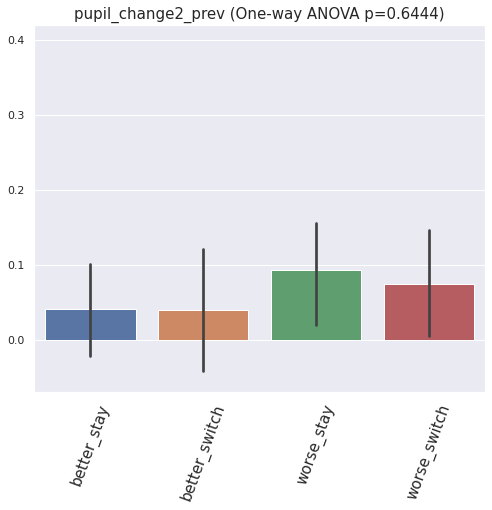

In [165]:
from scipy.stats import f_oneway


gridsize = (1,1)
fig = plt.figure(figsize=(7, 7))

sns.barplot(data = arr_all_df)

plt.xticks(rotation=70, fontsize=15)
plt.ylim([-.07,0.42])
plt.tight_layout()

ss, ppp = f_oneway(arr_all_df.iloc[:,0], arr_all_df.iloc[:,1], arr_all_df.iloc[:,2], arr_all_df.iloc[:,3])
title = f'{columns_to_include} (One-way ANOVA p={round(ppp,4)})'
plt.title(title, fontsize=15)

In [155]:
arr_all_df.iloc[:,0]

0     0.332242
1     0.290063
2     0.163551
3     0.162048
4     0.102875
5     0.535618
6     0.100016
7     0.523867
8     0.379867
9     0.280957
10    0.489599
11    0.427780
12    0.052519
13    0.819150
14    0.269733
15    0.076074
16    0.604028
17   -0.119459
18    0.159823
19    0.194790
20    0.395560
21    0.288464
22    0.215791
23    0.157106
24    0.229024
25   -0.415284
26    0.150559
27    0.160319
28   -0.135741
29    0.293109
30    0.426530
31    0.283016
32    0.255830
33    0.753222
34    0.023807
35    0.098600
36    0.461471
37    0.602919
38   -0.165148
39    0.315698
40    0.146575
41    0.069546
42    0.205515
43    0.283819
44    0.407675
45    0.706591
46    0.452950
47    0.573514
48    0.203063
49    0.280203
50    0.404925
51    0.259738
Name: better_stay, dtype: float64

In [167]:
from scipy.stats import f_oneway

ss, ppp = f_oneway(arr_all_df.iloc[:,0], arr_all_df.iloc[:,1], arr_all_df.iloc[:,2], arr_all_df.iloc[:,3])


F_onewayResult(statistic=6.0864693621039825, pvalue=0.0005496562277273053)